# **Load ChEMBL data**

In [1]:
! python --version

Python 3.7.10


In [2]:
# Install ChEMBL web service package
! pip install chembl_webresource_client

In [3]:
# Import necessary libraries
import pandas as pd
from chembl_webresource_client.new_client import new_client

In [216]:
# Target search in ChEMBL database
target = new_client.target
target_query = target.search('CHEMBL1957')
targets = pd.DataFrame.from_dict(target_query)
targets.head()

,cross_references,organism,pref_name,score,species_group_flag,target_chembl_id,target_components,target_type,tax_id
0,"[{'xref_id': 'P08069', 'xref_name': None, 'xre...",Homo sapiens,Insulin-like growth factor I receptor,15.0,False,CHEMBL1957,"[{'accession': 'P08069', 'component_descriptio...",SINGLE PROTEIN,9606


In [217]:
# The first entry is what we need
selected_target = targets.target_chembl_id[0]
selected_target

'CHEMBL1957'

In [218]:
# Retrieve bioactivity data with standard_type='IC50'
activity = new_client.activity
res = activity.filter(target_chembl_id=selected_target).filter(standard_type="IC50")

In [219]:
df = pd.DataFrame.from_dict(res)
print(df.shape)
df.head(3)

(4380, 45)


,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,bao_label,canonical_smiles,data_validity_comment,data_validity_description,document_chembl_id,document_journal,document_year,ligand_efficiency,molecule_chembl_id,molecule_pref_name,parent_molecule_chembl_id,pchembl_value,potential_duplicate,qudt_units,record_id,relation,src_id,standard_flag,standard_relation,standard_text_value,standard_type,standard_units,standard_upper_value,standard_value,target_chembl_id,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,316959,[],CHEMBL698354,Inhibition of Insulin-like growth factor I rec...,B,None,None,BAO_0000190,BAO_0000357,single protein format,COc1cc2c(Nc3ccc(Br)cc3F)ncnc2cc1OCCn1ccnn1,None,None,CHEMBL1135889,J. Med. Chem.,2002.0,None,CHEMBL281872,ZD-4190,CHEMBL281872,None,False,http://www.openphacts.org/units/Nanomolar,35685,>,1,True,>,None,IC50,nM,None,20000.0,CHEMBL1957,Homo sapiens,Insulin-like growth factor I receptor,9606,None,None,IC50,uM,UO_0000065,None,20.0
1,None,328361,[],CHEMBL698355,Inhibition of Insulin-like growth factor I rec...,B,None,None,BAO_0000190,BAO_0000357,single protein format,COc1cc2c(Nc3ccc(Br)cc3F)ncnc2cc1OCC1CCN(C)CC1.Cl,None,None,CHEMBL1135889,J. Med. Chem.,2002.0,None,CHEMBL533849,None,CHEMBL24828,None,False,http://www.openphacts.org/units/Nanomolar,35684,>,1,True,>,None,IC50,nM,None,20000.0,CHEMBL1957,Homo sapiens,Insulin-like growth factor I receptor,9606,None,None,IC50,uM,UO_0000065,None,20.0
2,None,586962,[],CHEMBL814329,In vitro inhibitory concentration of compound ...,B,None,None,BAO_0000190,BAO_0000357,single protein format,CC(C)(C)c1cnc(CSc2cnc(NC(=O)C3CCNCC3)s2)o1,None,None,CHEMBL1149325,J. Med. Chem.,2004.0,None,CHEMBL296468,BMS-387032,CHEMBL296468,None,False,http://www.openphacts.org/units/Nanomolar,79536,>,1,True,>,None,IC50,nM,None,25000.0,CHEMBL1957,Homo sapiens,Insulin-like growth factor I receptor,9606,None,None,IC50,uM,UO_0000065,None,25.0


In [220]:
from datetime import date

today = date.today().strftime('%m%d%y')
today

'041321'

In [221]:
raw_file_name = today+selected_target+'_raw_data.csv'
df.to_csv(raw_file_name, index=False)

# **Data Filtering**

In [222]:
df2 = pd.read_csv(raw_file_name)
df2.shape

(4380, 45)

## **Target Organism = 'Homo Sapiens'**

In [223]:
# Check if the data only has target_organism=='Homo sapiens'
print(pd.unique(df2['target_organism']))

# Filter data by target_organism=='Homo sapiens'
df2=df2[df2['target_organism'].isin(['Homo sapiens'])]
print(pd.unique(df2['target_organism']))
df2.shape

['Homo sapiens']
['Homo sapiens']


(4380, 45)

## **Standard Type = 'IC50'**

In [224]:
# Check if the data only has standard_type=='IC50'
print(pd.unique(df2['standard_type']))

# Filter data by standard_type=='IC50'
df2=df2[df2['standard_type'].isin(['IC50'])]
print(pd.unique(df2['standard_type']))
df2.shape

['IC50']
['IC50']


(4380, 45)

##**Standard Unit = ['nM', 'uM', 'pM']**

In [225]:
print(pd.unique(df2['standard_units']))
# Filter data by units = ['nM','uM','pM']
units = ['nM','uM','pM']
df2=df2[df2['standard_units'].isin(units)].reset_index().drop(columns='index')

print(pd.unique(df2['standard_units']))
df2.shape

['nM' nan 'ug.mL-1']
['nM']


(4326, 45)

In [226]:
filter_file_name = today+selected_target+'_filtered_data.csv'
df2.to_csv(filter_file_name, index=False)

# **Data Cleaning**


In [227]:
df3 = pd.read_csv(filter_file_name)
df3.shape

(4326, 45)

## **Drop Missing values**

* Drop missing SMILE notation
* Drop missing standard values


In [228]:
# Drop compounds with missing standard_value.
df3 = df3[df3['standard_value'].notna()]
print(df3.shape)

# Drop compounds with missing canonical_smiles column.
df3 = df3[df3['canonical_smiles'].notna()]
print(df3.shape)

# Reset index
df3 = df3.reset_index().drop(columns='index')
print(df3.shape)
df3.head(3)

(4326, 45)
(4326, 45)
(4326, 45)


,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,bao_label,canonical_smiles,data_validity_comment,data_validity_description,document_chembl_id,document_journal,document_year,ligand_efficiency,molecule_chembl_id,molecule_pref_name,parent_molecule_chembl_id,pchembl_value,potential_duplicate,qudt_units,record_id,relation,src_id,standard_flag,standard_relation,standard_text_value,standard_type,standard_units,standard_upper_value,standard_value,target_chembl_id,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,NaN,316959,[],CHEMBL698354,Inhibition of Insulin-like growth factor I rec...,B,NaN,NaN,BAO_0000190,BAO_0000357,single protein format,COc1cc2c(Nc3ccc(Br)cc3F)ncnc2cc1OCCn1ccnn1,NaN,NaN,CHEMBL1135889,J. Med. Chem.,2002.0,NaN,CHEMBL281872,ZD-4190,CHEMBL281872,NaN,False,http://www.openphacts.org/units/Nanomolar,35685,>,1,True,>,NaN,IC50,nM,NaN,20000.0,CHEMBL1957,Homo sapiens,Insulin-like growth factor I receptor,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,20.0
1,NaN,328361,[],CHEMBL698355,Inhibition of Insulin-like growth factor I rec...,B,NaN,NaN,BAO_0000190,BAO_0000357,single protein format,COc1cc2c(Nc3ccc(Br)cc3F)ncnc2cc1OCC1CCN(C)CC1.Cl,NaN,NaN,CHEMBL1135889,J. Med. Chem.,2002.0,NaN,CHEMBL533849,NaN,CHEMBL24828,NaN,False,http://www.openphacts.org/units/Nanomolar,35684,>,1,True,>,NaN,IC50,nM,NaN,20000.0,CHEMBL1957,Homo sapiens,Insulin-like growth factor I receptor,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,20.0
2,NaN,586962,[],CHEMBL814329,In vitro inhibitory concentration of compound ...,B,NaN,NaN,BAO_0000190,BAO_0000357,single protein format,CC(C)(C)c1cnc(CSc2cnc(NC(=O)C3CCNCC3)s2)o1,NaN,NaN,CHEMBL1149325,J. Med. Chem.,2004.0,NaN,CHEMBL296468,BMS-387032,CHEMBL296468,NaN,False,http://www.openphacts.org/units/Nanomolar,79536,>,1,True,>,NaN,IC50,nM,NaN,25000.0,CHEMBL1957,Homo sapiens,Insulin-like growth factor I receptor,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,25.0


## **Convert Standard Units (nM)**

In [229]:
#units = ['nM','uM','pM']

standard_unit_nM = []

for i,j in zip(df3['standard_units'],df3['standard_value']):
    if i == 'nM':
      standard_unit_nM.append(float(j))
    elif i == 'uM':
      standard_unit_nM.append(float(1000*float(j)))
    elif i == 'pM':
      standard_unit_nM.append(float(float(j)/1000))

In [230]:
#standard_unit_nM
standard_value_nM = pd.Series(standard_unit_nM, name='standard_value_nM')
print(standard_value_nM.shape)

(4326,)


In [231]:
print(df3.shape)

df3 = pd.concat([df3, standard_value_nM], axis=1)
print(df3.shape)

# Sort data by ascending 'standard_unit_nM' values.
df3 = df3.sort_values('standard_value_nM',ascending=True).reset_index().drop(columns='index')
df3.head(3)
#df3[['standard_value','standard_units','standard_value_nM']].loc[(df3['standard_units']=='uM')].tail(5)

(4326, 45)
(4326, 46)


,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,bao_label,canonical_smiles,data_validity_comment,data_validity_description,document_chembl_id,document_journal,document_year,ligand_efficiency,molecule_chembl_id,molecule_pref_name,parent_molecule_chembl_id,pchembl_value,potential_duplicate,qudt_units,record_id,relation,src_id,standard_flag,standard_relation,standard_text_value,standard_type,standard_units,standard_upper_value,standard_value,target_chembl_id,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value,standard_value_nM
0,332658.0,17711006,[],CHEMBL3887328,DELFIA Assay: The kinase activity is measured ...,B,NaN,NaN,BAO_0000190,BAO_0000357,single protein format,CN1CCN(CCn2ccc(Nc3ncc4c(n3)-c3c(nn(C)c3-c3ccc(...,NaN,NaN,CHEMBL3886278,NaN,2015.0,"{'bei': '18.74', 'le': '0.34', 'lle': '7.07', ...",CHEMBL3905758,NaN,CHEMBL3905758,10.3,False,http://www.openphacts.org/units/Nanomolar,2842588,=,37,True,=,NaN,IC50,nM,NaN,0.05,CHEMBL1957,Homo sapiens,Insulin-like growth factor I receptor,9606,NaN,NaN,IC50,nM,UO_0000065,NaN,0.05,0.05
1,332784.0,17711132,[],CHEMBL3887328,DELFIA Assay: The kinase activity is measured ...,B,NaN,NaN,BAO_0000190,BAO_0000357,single protein format,COc1cc(N2CCN(C(C)C)CC2)ccc1Nc1ncc2c(n1)-c1c(nn...,NaN,NaN,CHEMBL3886278,NaN,2015.0,"{'bei': '17.47', 'le': '0.32', 'lle': '4.97', ...",CHEMBL3950012,NaN,CHEMBL3950012,10.3,False,http://www.openphacts.org/units/Nanomolar,2842713,=,37,True,=,NaN,IC50,nM,NaN,0.05,CHEMBL1957,Homo sapiens,Insulin-like growth factor I receptor,9606,NaN,NaN,IC50,nM,UO_0000065,NaN,0.05,0.05
2,332764.0,17711112,[],CHEMBL3887328,DELFIA Assay: The kinase activity is measured ...,B,NaN,NaN,BAO_0000190,BAO_0000357,single protein format,COc1cc(C(=O)NCCCN(C)C)ccc1Nc1ncc2c(n1)-c1c(nn(...,NaN,NaN,CHEMBL3886278,NaN,2015.0,"{'bei': '16.67', 'le': '0.31', 'lle': '5.70', ...",CHEMBL3977170,NaN,CHEMBL3977170,10.1,False,http://www.openphacts.org/units/Nanomolar,2842693,=,37,True,=,NaN,IC50,nM,NaN,0.08,CHEMBL1957,Homo sapiens,Insulin-like growth factor I receptor,9606,NaN,NaN,IC50,nM,UO_0000065,NaN,0.08,0.08


## **Duplicated Compounds**

In [232]:
# Keep the one with minimum standard_value for duplicated ['compound_ID','target_ID']
df3 = df3.drop_duplicates(subset=['molecule_chembl_id','target_chembl_id'], keep='first').reset_index().drop(columns='index')
print(df3.shape)
df3.head(3)['standard_value_nM']

(2915, 46)


0    0.05
1    0.05
2    0.08
Name: standard_value_nM, dtype: float64

##**Keep only useful columns**
#### **molecule_chembl_id, target_chembl_id, canonical_smiles, standard_value_nM**

In [233]:
# Combine columns ('molecule_chembl_id','target_chembl_id','canonical_smiles','standard_value_nM') and bioactivity_class into a DataFrame
selection = ['molecule_chembl_id','target_chembl_id','canonical_smiles','standard_value_nM']
df3 = df3[selection] #.rename(columns={'Molecule ChEMBL ID':'molecule_chembl_id','Smiles':'canonical_smiles','standard_unit_nM':'standard_value'})
print(df3.shape)
df3

(2915, 4)


,molecule_chembl_id,target_chembl_id,canonical_smiles,standard_value_nM
0,CHEMBL3905758,CHEMBL1957,CN1CCN(CCn2ccc(Nc3ncc4c(n3)-c3c(nn(C)c3-c3ccc(...,0.05
1,CHEMBL3950012,CHEMBL1957,COc1cc(N2CCN(C(C)C)CC2)ccc1Nc1ncc2c(n1)-c1c(nn...,0.05
2,CHEMBL3977170,CHEMBL1957,COc1cc(C(=O)NCCCN(C)C)ccc1Nc1ncc2c(n1)-c1c(nn(...,0.08
3,CHEMBL3928243,CHEMBL1957,Cn1cc(-c2cccc(Cc3c4c(nn3C)CCc3cnc(Nc5ccn(CCCN6...,0.08
4,CHEMBL3979064,CHEMBL1957,COc1cc(N2CCN(C3CCOCC3)CC2)ccc1Nc1ncc2c(n1)-c1c...,0.08
...,...,...,...,...
2910,CHEMBL4216200,CHEMBL1957,COc1ccc(CNc2ccnc3oc4ccc(N)cc4c23)cc1,1000000.00
2911,CHEMBL4213021,CHEMBL1957,Nc1ccc2oc3nccc(NCc4cccc(Br)c4)c3c2c1,1000000.00
2912,CHEMBL3353410,CHEMBL1957,C=CC(=O)Nc1cc(Nc2nccc(-c3cn(C)c4ccccc34)n2)c(O...,2900000.00
2913,CHEMBL1956069,CHEMBL1957,COc1cccc(C(=O)c2sc(Nc3ccc(N4CCN(C(C)C)CC4)cc3)...,20000000.00


In [234]:
clean_file_name = today+selected_target+'_cleaned_data.csv'
df3.to_csv(clean_file_name, index=False)

# **Labeling** 

In [235]:
import pandas as pd
df4 = pd.read_csv(clean_file_name)
df4.shape

(2915, 4)

## **Normalization (pIC50)**


In [236]:
import numpy as np

def pIC50(input):
    pIC50 = []

    for i in input['standard_value_norm']:
        molar = i*(10**-9) # Converts nM to M
        pIC50.append(-np.log10(molar))

    input['pIC50'] = pIC50
    x = input.drop('standard_value_norm', 1)
        
    return x

In [237]:
def norm_value(input):
    norm = []

    for i in input['standard_value_nM']:
        #  Values greater than 100,000,000 will be fixed at 100,000,000 otherwise the negative logarithmic value will become negative.
        if i > 100000000:
          i = 100000000
        norm.append(i)

    input['standard_value_norm'] = norm
    x = input.drop('standard_value_nM', 1)
        
    return x

In [238]:
# Normalization
df5 = norm_value(df4)
df_norm = pIC50(df5)
df_norm.head(3) #.pIC50.describe()

,molecule_chembl_id,target_chembl_id,canonical_smiles,pIC50
0,CHEMBL3905758,CHEMBL1957,CN1CCN(CCn2ccc(Nc3ncc4c(n3)-c3c(nn(C)c3-c3ccc(...,10.30103
1,CHEMBL3950012,CHEMBL1957,COc1cc(N2CCN(C(C)C)CC2)ccc1Nc1ncc2c(n1)-c1c(nn...,10.30103
2,CHEMBL3977170,CHEMBL1957,COc1cc(C(=O)NCCCN(C)C)ccc1Nc1ncc2c(n1)-c1c(nn(...,10.09691


In [241]:
botton_line = np.percentile(df4['standard_value_nM'], 25)
top_line = np.percentile(df4['standard_value_nM'], 75)
print(' 25-th =',botton_line,'\n','75-th =',top_line)

 25-th = 18.0 
 75-th = 1159.0


In [244]:
botton_line = np.percentile(df_norm.pIC50, 25)
top_line = np.percentile(df_norm.pIC50, 75)
print(' 25-th =',botton_line,'\n','75-th =',top_line)

 25-th = 5.936034442059752 
 75-th = 7.7447274948966935


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


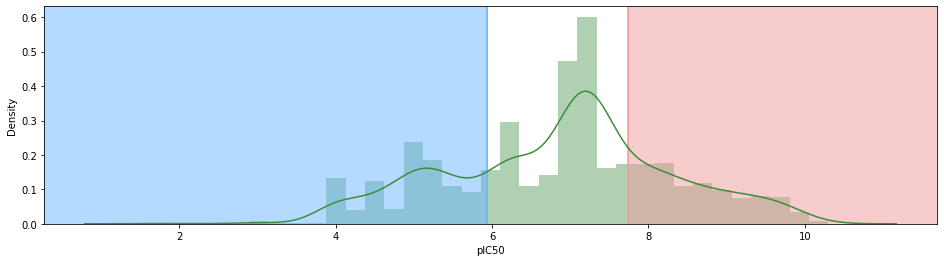

In [245]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 4))

#plotting the two lines
p1 = plt.axvline(x=botton_line,color='#6DB6FF')
p2 = plt.axvline(x=top_line,color='#EF9A9A')

#plotting the PDF
ax = sns.distplot(df_norm['pIC50'], hist=True, color='#388E3C')

xlim = ax.get_xlim()
ax.axvspan(xlim[0], botton_line, color='#6DB6FF', alpha=0.5)
ax.axvspan(top_line, xlim[1], color='#EF9A9A', alpha=0.5)
#reset xlim
ax.set_xlim(xlim)
plt.show()

In [246]:
label_plt_name = today+selected_target+'_pIC50_dist.png'
plt.savefig(label_plt_name)

<Figure size 432x288 with 0 Axes>

## **Labeling**

In [247]:
bioactivity_threshold = []
for i in df_norm.pIC50:
  if float(i) >= top_line:
    bioactivity_threshold.append(1)
  elif float(i) <= botton_line:
    bioactivity_threshold.append(0)
  else:
    bioactivity_threshold.append("intermediate")

In [248]:
# Combine the data
bioactivity_class = pd.Series(bioactivity_threshold, name='bioactivity_class')
df6 = pd.concat([df_norm, bioactivity_class], axis=1)
print(df6.shape)
df6.head(5)

(2915, 5)


,molecule_chembl_id,target_chembl_id,canonical_smiles,pIC50,bioactivity_class
0,CHEMBL3905758,CHEMBL1957,CN1CCN(CCn2ccc(Nc3ncc4c(n3)-c3c(nn(C)c3-c3ccc(...,10.30103,1
1,CHEMBL3950012,CHEMBL1957,COc1cc(N2CCN(C(C)C)CC2)ccc1Nc1ncc2c(n1)-c1c(nn...,10.30103,1
2,CHEMBL3977170,CHEMBL1957,COc1cc(C(=O)NCCCN(C)C)ccc1Nc1ncc2c(n1)-c1c(nn(...,10.09691,1
3,CHEMBL3928243,CHEMBL1957,Cn1cc(-c2cccc(Cc3c4c(nn3C)CCc3cnc(Nc5ccn(CCCN6...,10.09691,1
4,CHEMBL3979064,CHEMBL1957,COc1cc(N2CCN(C3CCOCC3)CC2)ccc1Nc1ncc2c(n1)-c1c...,10.09691,1


In [249]:
print(
    ' active',df6['bioactivity_class'][df6['bioactivity_class']==1].count(),'\n',
    'inactive',df6['bioactivity_class'][df6['bioactivity_class']==0].count(),'\n',
    'intermediate',df6['bioactivity_class'][df6['bioactivity_class']=="intermediate"].count()
)

 active 731 
 inactive 729 
 intermediate 1455


In [250]:
label_file_name = today+selected_target+'_3cls_labeled_data.csv'
df6.to_csv(label_file_name, index=False)

## **Removing 'intermediate' class**

In [251]:
df_2class = df6[df6['bioactivity_class'] != 'intermediate']
print(df_2class.shape)
df_2class.head(3)

(1460, 5)


,molecule_chembl_id,target_chembl_id,canonical_smiles,pIC50,bioactivity_class
0,CHEMBL3905758,CHEMBL1957,CN1CCN(CCn2ccc(Nc3ncc4c(n3)-c3c(nn(C)c3-c3ccc(...,10.30103,1
1,CHEMBL3950012,CHEMBL1957,COc1cc(N2CCN(C(C)C)CC2)ccc1Nc1ncc2c(n1)-c1c(nn...,10.30103,1
2,CHEMBL3977170,CHEMBL1957,COc1cc(C(=O)NCCCN(C)C)ccc1Nc1ncc2c(n1)-c1c(nn(...,10.09691,1


In [252]:
bi_label_file_name = today+selected_target+'_binary_2cls_labeled_data.csv'
df_2class.to_csv(bi_label_file_name, index=False)

#**(Multi-Labeled) Data Transformation**

##**Load existing mlc-data**

In [253]:
mlc_df = pd.read_csv('original_mlc_data.csv')

In [254]:
mlc_df.head(3)

,molecule_chembl_id,canonical_smiles,CHEMBL203,CHEMBL2842,CHEMBL614725
0,CHEMBL10,C[S+]([O-])c1ccc(-c2nc(-c3ccc(F)cc3)c(-c3ccncc...,0,0,0
1,CHEMBL101299,N[C@H]1CCN(c2c(F)cc3c(=O)c(C(=O)O)cn4c5ccccc5o...,0,0,1
2,CHEMBL101683,O=C(Nc1ccc(Cl)cc1)c1ccccc1NCc1ccncc1,0,0,0


In [255]:
existing_targets_ls=[]
existing_targets_ls = list(mlc_df.columns[2:])
existing_targets_ls

['CHEMBL203', 'CHEMBL2842', 'CHEMBL614725']

In [256]:
mlc_df[existing_targets_ls] = mlc_df[existing_targets_ls].astype('int')

print(mlc_df.shape)
mlc_df.head(2)

(6872, 5)


,molecule_chembl_id,canonical_smiles,CHEMBL203,CHEMBL2842,CHEMBL614725
0,CHEMBL10,C[S+]([O-])c1ccc(-c2nc(-c3ccc(F)cc3)c(-c3ccncc...,0,0,0
1,CHEMBL101299,N[C@H]1CCN(c2c(F)cc3c(=O)c(C(=O)O)cn4c5ccccc5o...,0,0,1


In [257]:
new_df = pd.read_csv(bi_label_file_name)
print(new_df.shape)
new_df.head(3)

(1460, 5)


,molecule_chembl_id,target_chembl_id,canonical_smiles,pIC50,bioactivity_class
0,CHEMBL3905758,CHEMBL1957,CN1CCN(CCn2ccc(Nc3ncc4c(n3)-c3c(nn(C)c3-c3ccc(...,10.30103,1
1,CHEMBL3950012,CHEMBL1957,COc1cc(N2CCN(C(C)C)CC2)ccc1Nc1ncc2c(n1)-c1c(nn...,10.30103,1
2,CHEMBL3977170,CHEMBL1957,COc1cc(C(=O)NCCCN(C)C)ccc1Nc1ncc2c(n1)-c1c(nn(...,10.09691,1


In [258]:
new_target = new_df.target_chembl_id[1]
existing_targets_ls.append(new_target)

selection = ['molecule_chembl_id','canonical_smiles','bioactivity_class']
new_df = new_df[selection].rename({'bioactivity_class': new_target}, axis='columns')
new_df.head(3)

,molecule_chembl_id,canonical_smiles,CHEMBL1957
0,CHEMBL3905758,CN1CCN(CCn2ccc(Nc3ncc4c(n3)-c3c(nn(C)c3-c3ccc(...,1
1,CHEMBL3950012,COc1cc(N2CCN(C(C)C)CC2)ccc1Nc1ncc2c(n1)-c1c(nn...,1
2,CHEMBL3977170,COc1cc(C(=O)NCCCN(C)C)ccc1Nc1ncc2c(n1)-c1c(nn(...,1


In [259]:
multi_concat = pd.concat([mlc_df, new_df])

multi_dup_df = multi_concat[multi_concat.duplicated(['molecule_chembl_id'])]
multi_dup_df.tail(3)

,molecule_chembl_id,canonical_smiles,CHEMBL203,CHEMBL2842,CHEMBL614725,CHEMBL1957
1454,CHEMBL4209296,Nc1ccc2oc3nccc(NCc4ccc(Cl)cc4)c3c2c1,NaN,NaN,NaN,0.0
1455,CHEMBL4216200,COc1ccc(CNc2ccnc3oc4ccc(N)cc4c23)cc1,NaN,NaN,NaN,0.0
1457,CHEMBL3353410,C=CC(=O)Nc1cc(Nc2nccc(-c3cn(C)c4ccccc34)n2)c(O...,NaN,NaN,NaN,0.0


##**Data Aggregation**

In [260]:
#multi_res = multi_concat.groupby(['molecule_chembl_id','canonical_smiles']).agg({'CHEMBL614725' : 'max',new_target : 'max'})
multi_res = multi_concat.groupby(['molecule_chembl_id','canonical_smiles']).agg({'CHEMBL203' : 'max', 'CHEMBL2842' : 'max', 'CHEMBL614725' : 'max', 'CHEMBL1957' : 'max'})#, 'CHEMBL1957' : 'max', new_target : 'max'})

In [261]:
multi_res = multi_res.fillna(0).astype('int')

multi_res.insert(loc=0, column='canonical_smiles', value=multi_res.index.get_level_values('canonical_smiles'))
multi_res.insert(loc=0, column='molecule_chembl_id', value=multi_res.index.get_level_values('molecule_chembl_id'))

multi_res = multi_res.reset_index(drop=True)

multi_res

,molecule_chembl_id,canonical_smiles,CHEMBL203,CHEMBL2842,CHEMBL614725,CHEMBL1957
0,CHEMBL10,C[S+]([O-])c1ccc(-c2nc(-c3ccc(F)cc3)c(-c3ccncc...,0,0,0,0
1,CHEMBL101253,Clc1ccc(Nc2nnc(Cc3ccncc3)c3ccccc23)cc1,0,0,0,0
2,CHEMBL101299,N[C@H]1CCN(c2c(F)cc3c(=O)c(C(=O)O)cn4c5ccccc5o...,0,0,1,0
3,CHEMBL101683,O=C(Nc1ccc(Cl)cc1)c1ccccc1NCc1ccncc1,0,0,0,0
4,CHEMBL101871,C[C@]1([C@H]2Cc3ccc4oc5c(N6CC[C@H](N)C6)c(F)cc...,0,0,1,0
...,...,...,...,...,...,...
8127,CHEMBL96926,C/C=C(/C)C(=O)O[C@H]1C(C)=C2[C@@H]3OC(=O)[C@@]...,0,0,1,0
8128,CHEMBL98137,COc1ccc(Nc2ccnc3cc(OC)c(OC)cc23)cc1OC,0,0,0,0
8129,CHEMBL98350,O=c1cc(N2CCOCC2)oc2c(-c3ccccc3)cccc12,0,0,0,0
8130,CHEMBL98934,COC1=CC(=O)C=C(/C=C2\CCCC3CCCCC23)C1=O,0,0,0,0


In [262]:
#check
#multi_res[multi_res['molecule_chembl_id']=='CHEMBL1289926']

In [263]:
multi_res[multi_res.duplicated(['molecule_chembl_id'])].count()['molecule_chembl_id']

0

In [264]:
multi_res.head(3)

,molecule_chembl_id,canonical_smiles,CHEMBL203,CHEMBL2842,CHEMBL614725,CHEMBL1957
0,CHEMBL10,C[S+]([O-])c1ccc(-c2nc(-c3ccc(F)cc3)c(-c3ccncc...,0,0,0,0
1,CHEMBL101253,Clc1ccc(Nc2nnc(Cc3ccncc3)c3ccccc23)cc1,0,0,0,0
2,CHEMBL101299,N[C@H]1CCN(c2c(F)cc3c(=O)c(C(=O)O)cn4c5ccccc5o...,0,0,1,0


In [265]:
mul_label_file_name = today+selected_target+'_multi_2cls_labeled_data.csv'
multi_res.to_csv(mul_label_file_name, index=False)

##**Update original_mlc_data.csv**

In [266]:
multi_res.to_csv('original_mlc_data.csv', index=False)

# **Calculate PubChem fingerprint**

In [267]:
df_mul = pd.read_csv(mul_label_file_name)
print(df_mul.shape)
df_mul.tail(3)

(8132, 6)


,molecule_chembl_id,canonical_smiles,CHEMBL203,CHEMBL2842,CHEMBL614725,CHEMBL1957
8129,CHEMBL98350,O=c1cc(N2CCOCC2)oc2c(-c3ccccc3)cccc12,0,0,0,0
8130,CHEMBL98934,COC1=CC(=O)C=C(/C=C2\CCCC3CCCCC23)C1=O,0,0,0,0
8131,CHEMBL99743,COc1cc2ncnc(N3CCN(C(=O)Nc4ccc([N+](=O)[O-])cc4...,0,0,0,0


In [268]:
df_bi = pd.read_csv(bi_label_file_name)
print(df_bi.shape)
df_bi.tail(3)

(1460, 5)


,molecule_chembl_id,target_chembl_id,canonical_smiles,pIC50,bioactivity_class
1457,CHEMBL3353410,CHEMBL1957,C=CC(=O)Nc1cc(Nc2nccc(-c3cn(C)c4ccccc34)n2)c(O...,2.537602,0
1458,CHEMBL1956069,CHEMBL1957,COc1cccc(C(=O)c2sc(Nc3ccc(N4CCN(C(C)C)CC4)cc3)...,1.698970,0
1459,CHEMBL1956070,CHEMBL1957,CN1CCN(c2ccc(Nc3nc(N)c(C(=O)c4ccc5c(c4)OCCO5)s...,1.657577,0


## **Download PaDEL-Descriptor**

In [58]:
! wget http://www.yapcwsoft.com/dd/padeldescriptor/PaDEL-Descriptor.zip

--2021-04-13 19:55:42--  http://www.yapcwsoft.com/dd/padeldescriptor/PaDEL-Descriptor.zip
Resolving www.yapcwsoft.com (www.yapcwsoft.com)... 118.189.195.172
Connecting to www.yapcwsoft.com (www.yapcwsoft.com)|118.189.195.172|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20875190 (20M) [application/zip]
Saving to: ‘PaDEL-Descriptor.zip’

PaDEL-Descriptor.zi 100%[===================>]  19.91M  6.66MB/s    in 3.0s    

2021-04-13 19:55:45 (6.66 MB/s) - ‘PaDEL-Descriptor.zip’ saved [20875190/20875190]



In [59]:
! unzip PaDEL-Descriptor.zip

Archive:  PaDEL-Descriptor.zip
  inflating: Descriptors.xls         
  inflating: descriptors.xml         
   creating: lib/
  inflating: lib/ambit2-base-2.4.7-SNAPSHOT.jar  
  inflating: lib/ambit2-core-2.4.7-SNAPSHOT.jar  
  inflating: lib/ambit2-smarts-2.4.7-SNAPSHOT.jar  
  inflating: lib/appframework-1.0.3.jar  
  inflating: lib/cdk-1.4.15.jar      
  inflating: lib/commons-cli-1.2.jar  
  inflating: lib/guava-17.0.jar      
  inflating: lib/jama.jar            
  inflating: lib/jgrapht-0.6.0.jar   
  inflating: lib/l2fprod-common-all.jar  
  inflating: lib/libPaDEL-Descriptor.jar  
  inflating: lib/libPaDEL-Jobs.jar   
  inflating: lib/libPaDEL.jar        
  inflating: lib/swing-worker-1.1.jar  
  inflating: lib/vecmath1.2-1.14.jar  
  inflating: lib/xom-1.1.jar         
   creating: license/
  inflating: license/lgpl-2.1.txt    
  inflating: license/lgpl.license    
  inflating: license/LICENSE.txt     
  inflating: license/README - CDK    
  inflating: PaDEL-Descriptor.jar    


In [60]:
# Modify the descriptors.xml file for calculation
import lxml.etree

# input
doc = lxml.etree.parse('descriptors.xml')
# modification
for el in doc.xpath("//Descriptor[@name!='PubchemFingerprinter']"):
  el.attrib['value'] = 'false'
# output
# open('output_file.xml', 'w').write(lxml.etree.tostring(doc))
doc.write('pubchemfingerprinter.xml')

## **Calculate Pubchem Fingerprints**

###**Binary**

In [269]:
selection = ['canonical_smiles','molecule_chembl_id']
df_bi_selection = df_bi[selection]
print(df_bi_selection.shape)
df_bi_selection.to_csv('molecule.smi', sep='\t', index=False, header=False)

(1460, 2)


In [270]:
! cat molecule.smi | head -5

CN1CCN(CCn2ccc(Nc3ncc4c(n3)-c3c(nn(C)c3-c3ccc(-c5cnn(C)c5)cc3)CC4)n2)CC1	CHEMBL3905758
COc1cc(N2CCN(C(C)C)CC2)ccc1Nc1ncc2c(n1)-c1c(nn(C)c1-c1ccc(-c3cnn(C)c3)cc1)CC2	CHEMBL3950012
COc1cc(C(=O)NCCCN(C)C)ccc1Nc1ncc2c(n1)-c1c(nn(C)c1Cc1cccc(-c3cnn(C)c3)c1)CC2	CHEMBL3977170
Cn1cc(-c2cccc(Cc3c4c(nn3C)CCc3cnc(Nc5ccn(CCCN6CCCC6)n5)nc3-4)c2)cn1	CHEMBL3928243
COc1cc(N2CCN(C3CCOCC3)CC2)ccc1Nc1ncc2c(n1)-c1c(nn(C)c1-c1ccc(-c3cnn(C)c3)cc1)CC2	CHEMBL3979064


In [271]:
! cat molecule.smi | wc -l

1460


In [272]:
! java -Xms1G -Xmx1G -Djava.awt.headless=true -jar ./PaDEL-Descriptor.jar -removesalt -standardizenitro -fingerprints -descriptortypes ./pubchemfingerprinter.xml -dir ./ -file binary_descriptors_output.csv

Processing CHEMBL3905758 in molecule.smi (1/1460). 
Processing CHEMBL3950012 in molecule.smi (2/1460). 
Processing CHEMBL3977170 in molecule.smi (3/1460). Average speed: 8.46 s/mol.
Processing CHEMBL3928243 in molecule.smi (4/1460). Average speed: 4.62 s/mol.
Processing CHEMBL3979064 in molecule.smi (5/1460). Average speed: 3.57 s/mol.
Processing CHEMBL3955626 in molecule.smi (6/1460). Average speed: 2.73 s/mol.
Processing CHEMBL3979509 in molecule.smi (7/1460). Average speed: 3.12 s/mol.
Processing CHEMBL3896205 in molecule.smi (8/1460). Average speed: 2.10 s/mol.
Processing CHEMBL3969930 in molecule.smi (9/1460). Average speed: 2.27 s/mol.
Processing CHEMBL3893323 in molecule.smi (10/1460). Average speed: 1.72 s/mol.
Processing CHEMBL3892425 in molecule.smi (11/1460). Average speed: 1.64 s/mol.
Processing CHEMBL3916799 in molecule.smi (12/1460). Average speed: 1.65 s/mol.
Processing CHEMBL3952080 in molecule.smi (13/1460). Average speed: 1.57 s/mol.
Processing CHEMBL3985408 in molecu

In [273]:
! ls -l

total 170060
-rw-r--r-- 1 root root   319131 Apr 13 21:24 041321CHEMBL1957_3cls_labeled_data.csv
-rw-r--r-- 1 root root   148075 Apr 13 21:24 041321CHEMBL1957_binary_2cls_labeled_data.csv
-rw-r--r-- 1 root root   270153 Apr 13 21:22 041321CHEMBL1957_cleaned_data.csv
-rw-r--r-- 1 root root  2954472 Apr 13 21:22 041321CHEMBL1957_filtered_data.csv
-rw-r--r-- 1 root root   632162 Apr 13 21:25 041321CHEMBL1957_multi_2cls_labeled_data.csv
-rw-r--r-- 1 root root     1273 Apr 13 21:24 041321CHEMBL1957_pIC50_dist.png
-rw-r--r-- 1 root root  2977409 Apr 13 21:22 041321CHEMBL1957_raw_data.csv
-rw-r--r-- 1 root root   857825 Apr 13 19:51 041321CHEMBL203_3cls_labeled_data.csv
-rw-r--r-- 1 root root   394645 Apr 13 19:52 041321CHEMBL203_binary_2cls_labeled_data.csv
-rw-r--r-- 1 root root  7889250 Apr 13 20:10 041321CHEMBL203_binary_FP_all_data.csv
-rw-r--r-- 1 root root  7503069 Apr 13 20:14 041321CHEMBL203_Binary_modeling_dataset.csv
-rw-r--r-- 1 root root   716088 Apr 13 19:45 041321CHEMBL203_clea

In [274]:
bi_df_fp = pd.read_csv('binary_descriptors_output.csv')
bi_df_fp = bi_df_fp.rename({'Name': 'molecule_chembl_id'}, axis='columns')
print(bi_df_fp.shape)
bi_df_fp.tail(3)

(1460, 882)


,molecule_chembl_id,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,PubchemFP10,PubchemFP11,PubchemFP12,PubchemFP13,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP17,PubchemFP18,PubchemFP19,PubchemFP20,PubchemFP21,PubchemFP22,PubchemFP23,PubchemFP24,PubchemFP25,PubchemFP26,PubchemFP27,PubchemFP28,PubchemFP29,PubchemFP30,PubchemFP31,PubchemFP32,PubchemFP33,PubchemFP34,PubchemFP35,PubchemFP36,PubchemFP37,PubchemFP38,...,PubchemFP841,PubchemFP842,PubchemFP843,PubchemFP844,PubchemFP845,PubchemFP846,PubchemFP847,PubchemFP848,PubchemFP849,PubchemFP850,PubchemFP851,PubchemFP852,PubchemFP853,PubchemFP854,PubchemFP855,PubchemFP856,PubchemFP857,PubchemFP858,PubchemFP859,PubchemFP860,PubchemFP861,PubchemFP862,PubchemFP863,PubchemFP864,PubchemFP865,PubchemFP866,PubchemFP867,PubchemFP868,PubchemFP869,PubchemFP870,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
1457,CHEMBL3353410,1,1,1,1,0,0,0,0,0,1,1,1,1,0,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1458,CHEMBL1956069,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1459,CHEMBL1956070,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [275]:
bi_df_all = pd.merge(df_bi,bi_df_fp, on="molecule_chembl_id")
print(bi_df_all.shape)
bi_df_all.tail(3)

(1460, 886)


,molecule_chembl_id,target_chembl_id,canonical_smiles,pIC50,bioactivity_class,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,PubchemFP10,PubchemFP11,PubchemFP12,PubchemFP13,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP17,PubchemFP18,PubchemFP19,PubchemFP20,PubchemFP21,PubchemFP22,PubchemFP23,PubchemFP24,PubchemFP25,PubchemFP26,PubchemFP27,PubchemFP28,PubchemFP29,PubchemFP30,PubchemFP31,PubchemFP32,PubchemFP33,PubchemFP34,...,PubchemFP841,PubchemFP842,PubchemFP843,PubchemFP844,PubchemFP845,PubchemFP846,PubchemFP847,PubchemFP848,PubchemFP849,PubchemFP850,PubchemFP851,PubchemFP852,PubchemFP853,PubchemFP854,PubchemFP855,PubchemFP856,PubchemFP857,PubchemFP858,PubchemFP859,PubchemFP860,PubchemFP861,PubchemFP862,PubchemFP863,PubchemFP864,PubchemFP865,PubchemFP866,PubchemFP867,PubchemFP868,PubchemFP869,PubchemFP870,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
1457,CHEMBL3353410,CHEMBL1957,C=CC(=O)Nc1cc(Nc2nccc(-c3cn(C)c4ccccc34)n2)c(O...,2.537602,0,1,1,1,1,0,0,0,0,0,1,1,1,1,0,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1458,CHEMBL1956069,CHEMBL1957,COc1cccc(C(=O)c2sc(Nc3ccc(N4CCN(C(C)C)CC4)cc3)...,1.698970,0,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1459,CHEMBL1956070,CHEMBL1957,CN1CCN(c2ccc(Nc3nc(N)c(C(=O)c4ccc5c(c4)OCCO5)s...,1.657577,0,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [276]:
binary_fp_file_name = today+selected_target+'_binary_FP_all_data.csv'
bi_df_all.to_csv(binary_fp_file_name, index=False)

###**Multi_Labeled**

In [277]:
selection = ['canonical_smiles','molecule_chembl_id']
df_mul_selection = df_mul[selection]
print(df_mul_selection.shape)
df_mul_selection.to_csv('molecule.smi', sep='\t', index=False, header=False)

(8132, 2)


In [278]:
! cat molecule.smi | head -5

C[S+]([O-])c1ccc(-c2nc(-c3ccc(F)cc3)c(-c3ccncc3)[nH]2)cc1	CHEMBL10
Clc1ccc(Nc2nnc(Cc3ccncc3)c3ccccc23)cc1	CHEMBL101253
N[C@H]1CCN(c2c(F)cc3c(=O)c(C(=O)O)cn4c5ccccc5oc2c34)C1	CHEMBL101299
O=C(Nc1ccc(Cl)cc1)c1ccccc1NCc1ccncc1	CHEMBL101683
C[C@]1([C@H]2Cc3ccc4oc5c(N6CC[C@H](N)C6)c(F)cc6c(=O)c(C(=O)O)cn(c4c3O2)c56)CO1	CHEMBL101871


In [279]:
! cat molecule.smi | wc -l

8132


In [280]:
! java -Xms1G -Xmx1G -Djava.awt.headless=true -jar ./PaDEL-Descriptor.jar -removesalt -standardizenitro -fingerprints -descriptortypes ./pubchemfingerprinter.xml -dir ./ -file multi_descriptors_output.csv

Streaming output truncated to the last 5000 lines.
Processing CHEMBL3358288 in molecule.smi (3134/8132). Average speed: 0.21 s/mol.
Processing CHEMBL3358966 in molecule.smi (3135/8132). Average speed: 0.21 s/mol.
Processing CHEMBL3360065 in molecule.smi (3136/8132). Average speed: 0.21 s/mol.
Processing CHEMBL3360071 in molecule.smi (3137/8132). Average speed: 0.21 s/mol.
Processing CHEMBL3360082 in molecule.smi (3138/8132). Average speed: 0.21 s/mol.
Processing CHEMBL3360085 in molecule.smi (3139/8132). Average speed: 0.21 s/mol.
Processing CHEMBL3360203 in molecule.smi (3140/8132). Average speed: 0.21 s/mol.
Processing CHEMBL3360602 in molecule.smi (3141/8132). Average speed: 0.21 s/mol.
Processing CHEMBL3360603 in molecule.smi (3142/8132). Average speed: 0.21 s/mol.
Processing CHEMBL3360604 in molecule.smi (3143/8132). Average speed: 0.21 s/mol.
Processing CHEMBL3360605 in molecule.smi (3144/8132). Average speed: 0.21 s/mol.
Processing CHEMBL3360606 in molecule.smi (3145/8132). Aver

In [281]:
! ls -l

total 187304
-rw-r--r-- 1 root root   319131 Apr 13 21:24 041321CHEMBL1957_3cls_labeled_data.csv
-rw-r--r-- 1 root root   148075 Apr 13 21:24 041321CHEMBL1957_binary_2cls_labeled_data.csv
-rw-r--r-- 1 root root  2731969 Apr 13 21:32 041321CHEMBL1957_binary_FP_all_data.csv
-rw-r--r-- 1 root root   270153 Apr 13 21:22 041321CHEMBL1957_cleaned_data.csv
-rw-r--r-- 1 root root  2954472 Apr 13 21:22 041321CHEMBL1957_filtered_data.csv
-rw-r--r-- 1 root root   632162 Apr 13 21:25 041321CHEMBL1957_multi_2cls_labeled_data.csv
-rw-r--r-- 1 root root     1273 Apr 13 21:24 041321CHEMBL1957_pIC50_dist.png
-rw-r--r-- 1 root root  2977409 Apr 13 21:22 041321CHEMBL1957_raw_data.csv
-rw-r--r-- 1 root root   857825 Apr 13 19:51 041321CHEMBL203_3cls_labeled_data.csv
-rw-r--r-- 1 root root   394645 Apr 13 19:52 041321CHEMBL203_binary_2cls_labeled_data.csv
-rw-r--r-- 1 root root  7889250 Apr 13 20:10 041321CHEMBL203_binary_FP_all_data.csv
-rw-r--r-- 1 root root  7503069 Apr 13 20:14 041321CHEMBL203_Binary_m

In [282]:
multi_df_fp = pd.read_csv('multi_descriptors_output.csv')
multi_df_fp = multi_df_fp.rename({'Name': 'molecule_chembl_id'}, axis='columns')
print(multi_df_fp.shape)
multi_df_fp.tail(3)

(8132, 882)


,molecule_chembl_id,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,PubchemFP10,PubchemFP11,PubchemFP12,PubchemFP13,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP17,PubchemFP18,PubchemFP19,PubchemFP20,PubchemFP21,PubchemFP22,PubchemFP23,PubchemFP24,PubchemFP25,PubchemFP26,PubchemFP27,PubchemFP28,PubchemFP29,PubchemFP30,PubchemFP31,PubchemFP32,PubchemFP33,PubchemFP34,PubchemFP35,PubchemFP36,PubchemFP37,PubchemFP38,...,PubchemFP841,PubchemFP842,PubchemFP843,PubchemFP844,PubchemFP845,PubchemFP846,PubchemFP847,PubchemFP848,PubchemFP849,PubchemFP850,PubchemFP851,PubchemFP852,PubchemFP853,PubchemFP854,PubchemFP855,PubchemFP856,PubchemFP857,PubchemFP858,PubchemFP859,PubchemFP860,PubchemFP861,PubchemFP862,PubchemFP863,PubchemFP864,PubchemFP865,PubchemFP866,PubchemFP867,PubchemFP868,PubchemFP869,PubchemFP870,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
8129,CHEMBL98934,1,1,1,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8130,CHEMBL98350,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8131,CHEMBL99743,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [283]:
multi_df_all = pd.merge(df_mul,multi_df_fp, on="molecule_chembl_id")
print(multi_df_all.shape)
multi_df_all.tail(3)

(8132, 887)


,molecule_chembl_id,canonical_smiles,CHEMBL203,CHEMBL2842,CHEMBL614725,CHEMBL1957,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,PubchemFP10,PubchemFP11,PubchemFP12,PubchemFP13,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP17,PubchemFP18,PubchemFP19,PubchemFP20,PubchemFP21,PubchemFP22,PubchemFP23,PubchemFP24,PubchemFP25,PubchemFP26,PubchemFP27,PubchemFP28,PubchemFP29,PubchemFP30,PubchemFP31,PubchemFP32,PubchemFP33,...,PubchemFP841,PubchemFP842,PubchemFP843,PubchemFP844,PubchemFP845,PubchemFP846,PubchemFP847,PubchemFP848,PubchemFP849,PubchemFP850,PubchemFP851,PubchemFP852,PubchemFP853,PubchemFP854,PubchemFP855,PubchemFP856,PubchemFP857,PubchemFP858,PubchemFP859,PubchemFP860,PubchemFP861,PubchemFP862,PubchemFP863,PubchemFP864,PubchemFP865,PubchemFP866,PubchemFP867,PubchemFP868,PubchemFP869,PubchemFP870,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
8129,CHEMBL98350,O=c1cc(N2CCOCC2)oc2c(-c3ccccc3)cccc12,0,0,0,0,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8130,CHEMBL98934,COC1=CC(=O)C=C(/C=C2\CCCC3CCCCC23)C1=O,0,0,0,0,1,1,1,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8131,CHEMBL99743,COc1cc2ncnc(N3CCN(C(=O)Nc4ccc([N+](=O)[O-])cc4...,0,0,0,0,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [284]:
multi_fp_file_name = today+'_multi_FP_all_data.csv'
multi_df_all.to_csv(multi_fp_file_name, index=False)

# **Preparing the X and Y data matrices**

##**Binary**

In [285]:
df8 = pd.read_csv(binary_fp_file_name)
df8.shape

(1460, 886)

### **X data matrix**

In [286]:
selection = ['molecule_chembl_id','target_chembl_id','canonical_smiles','pIC50','bioactivity_class']

In [287]:
df_X = df8.drop(columns=selection)
print(df_X.shape)
df_X.tail(3)

(1460, 881)


,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,PubchemFP10,PubchemFP11,PubchemFP12,PubchemFP13,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP17,PubchemFP18,PubchemFP19,PubchemFP20,PubchemFP21,PubchemFP22,PubchemFP23,PubchemFP24,PubchemFP25,PubchemFP26,PubchemFP27,PubchemFP28,PubchemFP29,PubchemFP30,PubchemFP31,PubchemFP32,PubchemFP33,PubchemFP34,PubchemFP35,PubchemFP36,PubchemFP37,PubchemFP38,PubchemFP39,...,PubchemFP841,PubchemFP842,PubchemFP843,PubchemFP844,PubchemFP845,PubchemFP846,PubchemFP847,PubchemFP848,PubchemFP849,PubchemFP850,PubchemFP851,PubchemFP852,PubchemFP853,PubchemFP854,PubchemFP855,PubchemFP856,PubchemFP857,PubchemFP858,PubchemFP859,PubchemFP860,PubchemFP861,PubchemFP862,PubchemFP863,PubchemFP864,PubchemFP865,PubchemFP866,PubchemFP867,PubchemFP868,PubchemFP869,PubchemFP870,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
1457,1,1,1,1,0,0,0,0,0,1,1,1,1,0,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1458,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1459,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### **Y variable**

In [288]:
df_Y = df8.bioactivity_class

### **Dataset for Modeling**

In [289]:
df9 = pd.concat([df_Y,df_X], axis=1)
print(df9.shape)
df9.tail(3)

(1460, 882)


,bioactivity_class,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,PubchemFP10,PubchemFP11,PubchemFP12,PubchemFP13,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP17,PubchemFP18,PubchemFP19,PubchemFP20,PubchemFP21,PubchemFP22,PubchemFP23,PubchemFP24,PubchemFP25,PubchemFP26,PubchemFP27,PubchemFP28,PubchemFP29,PubchemFP30,PubchemFP31,PubchemFP32,PubchemFP33,PubchemFP34,PubchemFP35,PubchemFP36,PubchemFP37,PubchemFP38,...,PubchemFP841,PubchemFP842,PubchemFP843,PubchemFP844,PubchemFP845,PubchemFP846,PubchemFP847,PubchemFP848,PubchemFP849,PubchemFP850,PubchemFP851,PubchemFP852,PubchemFP853,PubchemFP854,PubchemFP855,PubchemFP856,PubchemFP857,PubchemFP858,PubchemFP859,PubchemFP860,PubchemFP861,PubchemFP862,PubchemFP863,PubchemFP864,PubchemFP865,PubchemFP866,PubchemFP867,PubchemFP868,PubchemFP869,PubchemFP870,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
1457,0,1,1,1,1,0,0,0,0,0,1,1,1,1,0,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1458,0,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1459,0,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [290]:
binary_dataset_filename = today+selected_target+'_Binary_modeling_dataset.csv'
df9.to_csv(binary_dataset_filename, index=False)

## **Multi-labeled**

In [291]:
df10 = pd.read_csv(multi_fp_file_name)
df10.shape

(8132, 887)

### **X data matrix**

In [292]:
adds = ['molecule_chembl_id','canonical_smiles']

In [293]:
selections = existing_targets_ls + adds

In [294]:
df_X = df10.drop(columns=selections)
print(df_X.shape)
df_X.tail(3)

(8132, 881)


,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,PubchemFP10,PubchemFP11,PubchemFP12,PubchemFP13,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP17,PubchemFP18,PubchemFP19,PubchemFP20,PubchemFP21,PubchemFP22,PubchemFP23,PubchemFP24,PubchemFP25,PubchemFP26,PubchemFP27,PubchemFP28,PubchemFP29,PubchemFP30,PubchemFP31,PubchemFP32,PubchemFP33,PubchemFP34,PubchemFP35,PubchemFP36,PubchemFP37,PubchemFP38,PubchemFP39,...,PubchemFP841,PubchemFP842,PubchemFP843,PubchemFP844,PubchemFP845,PubchemFP846,PubchemFP847,PubchemFP848,PubchemFP849,PubchemFP850,PubchemFP851,PubchemFP852,PubchemFP853,PubchemFP854,PubchemFP855,PubchemFP856,PubchemFP857,PubchemFP858,PubchemFP859,PubchemFP860,PubchemFP861,PubchemFP862,PubchemFP863,PubchemFP864,PubchemFP865,PubchemFP866,PubchemFP867,PubchemFP868,PubchemFP869,PubchemFP870,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
8129,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8130,1,1,1,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8131,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### **Y variable**

In [295]:
df_Y = df10[existing_targets_ls]
print(df_Y.shape)
df_Y.tail(3)

(8132, 4)


,CHEMBL203,CHEMBL2842,CHEMBL614725,CHEMBL1957
8129,0,0,0,0
8130,0,0,0,0
8131,0,0,0,0


### **Dataset for Modeling**

In [296]:
df11 = pd.concat([df_Y,df_X], axis=1)
print(df11.shape)
df11.head(3)

(8132, 885)


,CHEMBL203,CHEMBL2842,CHEMBL614725,CHEMBL1957,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,PubchemFP10,PubchemFP11,PubchemFP12,PubchemFP13,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP17,PubchemFP18,PubchemFP19,PubchemFP20,PubchemFP21,PubchemFP22,PubchemFP23,PubchemFP24,PubchemFP25,PubchemFP26,PubchemFP27,PubchemFP28,PubchemFP29,PubchemFP30,PubchemFP31,PubchemFP32,PubchemFP33,PubchemFP34,PubchemFP35,...,PubchemFP841,PubchemFP842,PubchemFP843,PubchemFP844,PubchemFP845,PubchemFP846,PubchemFP847,PubchemFP848,PubchemFP849,PubchemFP850,PubchemFP851,PubchemFP852,PubchemFP853,PubchemFP854,PubchemFP855,PubchemFP856,PubchemFP857,PubchemFP858,PubchemFP859,PubchemFP860,PubchemFP861,PubchemFP862,PubchemFP863,PubchemFP864,PubchemFP865,PubchemFP866,PubchemFP867,PubchemFP868,PubchemFP869,PubchemFP870,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,0,0,0,0,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,1,0,0,0,0,0,0,0,1,1,1,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,0,0,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [297]:
multi_dataset_filename = today+'_Multi_modeling_dataset.csv'
df11.to_csv(multi_dataset_filename, index=False)

In [ ]:
#multi_dataset_filename = selected_target+'_Multi_modeling_dataset.csv'

In [ ]:
#binary_dataset_filename = selected_target+'_Binary_modeling_dataset.csv'

#**Install conda and rdkid**

In [298]:
# Install conda and rdkit
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
! conda install -c rdkit rdkit -y
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

--2021-04-13 22:07:56--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8303, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85055499 (81M) [application/x-sh]
Saving to: ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh.1’

Miniconda3-py37_4.8 100%[===================>]  81.12M   130MB/s    in 0.6s    

2021-04-13 22:07:57 (130 MB/s) - ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh.1’ saved [85055499/85055499]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: / - \ | / - \ | / - \ | failed with initial frozen solve. Retrying with flexible solve.
Solving environment: - \ | / - \ | / - \ | failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: | / - \ | / - \ | / 

In [299]:
import rdkit

#**Modeling - Multi-labeled**

In [300]:
#selected_target = 'CHEMBL1955'
#multi_dataset_filename = 'CHEMBL1955_Multi_modeling_dataset.csv'
#existing_targets_ls = ['CHEMBL203','CHEMBL1957','CHEMBL2842','CHEMBL614725','CHEMBL1955']

In [301]:
import pandas as pd

mdf = pd.read_csv(multi_dataset_filename)
mdf.head(2)

,CHEMBL203,CHEMBL2842,CHEMBL614725,CHEMBL1957,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,PubchemFP10,PubchemFP11,PubchemFP12,PubchemFP13,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP17,PubchemFP18,PubchemFP19,PubchemFP20,PubchemFP21,PubchemFP22,PubchemFP23,PubchemFP24,PubchemFP25,PubchemFP26,PubchemFP27,PubchemFP28,PubchemFP29,PubchemFP30,PubchemFP31,PubchemFP32,PubchemFP33,PubchemFP34,PubchemFP35,...,PubchemFP841,PubchemFP842,PubchemFP843,PubchemFP844,PubchemFP845,PubchemFP846,PubchemFP847,PubchemFP848,PubchemFP849,PubchemFP850,PubchemFP851,PubchemFP852,PubchemFP853,PubchemFP854,PubchemFP855,PubchemFP856,PubchemFP857,PubchemFP858,PubchemFP859,PubchemFP860,PubchemFP861,PubchemFP862,PubchemFP863,PubchemFP864,PubchemFP865,PubchemFP866,PubchemFP867,PubchemFP868,PubchemFP869,PubchemFP870,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,0,0,0,0,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,1,0,0,0,0,0,0,0,1,1,1,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [302]:
print(existing_targets_ls)
mdf_X = mdf.drop(columns=existing_targets_ls)
mdf_X.head(2)

['CHEMBL203', 'CHEMBL2842', 'CHEMBL614725', 'CHEMBL1957']


,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,PubchemFP10,PubchemFP11,PubchemFP12,PubchemFP13,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP17,PubchemFP18,PubchemFP19,PubchemFP20,PubchemFP21,PubchemFP22,PubchemFP23,PubchemFP24,PubchemFP25,PubchemFP26,PubchemFP27,PubchemFP28,PubchemFP29,PubchemFP30,PubchemFP31,PubchemFP32,PubchemFP33,PubchemFP34,PubchemFP35,PubchemFP36,PubchemFP37,PubchemFP38,PubchemFP39,...,PubchemFP841,PubchemFP842,PubchemFP843,PubchemFP844,PubchemFP845,PubchemFP846,PubchemFP847,PubchemFP848,PubchemFP849,PubchemFP850,PubchemFP851,PubchemFP852,PubchemFP853,PubchemFP854,PubchemFP855,PubchemFP856,PubchemFP857,PubchemFP858,PubchemFP859,PubchemFP860,PubchemFP861,PubchemFP862,PubchemFP863,PubchemFP864,PubchemFP865,PubchemFP866,PubchemFP867,PubchemFP868,PubchemFP869,PubchemFP870,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,1,1,1,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [303]:
mdf_Y = mdf[existing_targets_ls]
mdf_Y.head(2)

,CHEMBL203,CHEMBL2842,CHEMBL614725,CHEMBL1957
0,0,0,0,0
1,0,0,0,0


## **Split 80/20**

In [304]:
from sklearn.model_selection import train_test_split

In [305]:
my_train, my_test, mX_train, mX_test = train_test_split(mdf_Y, mdf_X, test_size=0.2)

In [306]:
mX_train.shape, my_train.shape, mX_test.shape, my_test.shape

((6505, 881), (6505, 4), (1627, 881), (1627, 4))

In [307]:
mX_train.to_csv('multi_X_train.csv', index=False)
mX_test.to_csv('multi_X_test.csv', index=False)
my_train.to_csv('multi_y_train.csv', index=False)
my_test.to_csv('multi_y_test.csv', index=False)

In [308]:
'''mX_train=pd.read_csv('multi_X_train.csv')
mX_test=pd.read_csv('multi_X_test.csv')
my_train=pd.read_csv('multi_y_train.csv')
my_test=pd.read_csv('multi_y_test.csv')'''

"mX_train=pd.read_csv('multi_X_train.csv')\nmX_test=pd.read_csv('multi_X_test.csv')\nmy_train=pd.read_csv('multi_y_train.csv')\nmy_test=pd.read_csv('multi_y_test.csv')"

In [309]:
# Split validation set (15%)
my_val_train, my_val, mX_val_train, mX_val= train_test_split(my_train, mX_train, test_size=0.15)

In [311]:
mX_val_train.shape, my_val_train.shape, mX_val.shape, my_val.shape

((5529, 881), (5529, 4), (976, 881), (976, 4))

In [310]:
mX_val_train.to_csv('multi_X_val_train.csv', index=False)
mX_val.to_csv('multi_X_val.csv', index=False)
my_val_train.to_csv('multi_y_val_train.csv', index=False)
my_val.to_csv('multi_y_val.csv', index=False)

In [ ]:
'''mX_val_train=pd.read_csv('multi_X_val_train.csv')
mX_val=pd.read_csv('multi_X_val.csv')
my_val_train=pd.read_csv('multi_y_val_train.csv')
my_val=pd.read_csv('multi_y_val.csv')'''

"mX_val_train=pd.read_csv('multi_X_val_train.csv')\nmX_val=pd.read_csv('multi_X_val.csv')\nmy_val_train=pd.read_csv('multi_y_val_train.csv')\nmy_val=pd.read_csv('multi_y_val.csv')"

## **Decision Tree**

In [312]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics #import accuracy_score, recall_score

In [313]:
# Decision Tree
# Hyper-tunning the 'criterion', 'max_depth', 'min_sample_leaf' and 'min_sample_split' parameter
criterion = ['gini', 'entropy']
max_depth = [1,2,3,4,5,6,7,8,10,20,50,100]
min_samples_leaf = [1,2,3,4,5,6,7,8,10,20,50]
min_samples_split = [2,3,4,5,6,7,8,10,20,50]
dt_accuracy_val = []
dt_accuracy_train = []
parameter = []
dt_df = pd.DataFrame(columns=['Parameters', 'val_Accuracy', 'train_Accuracy'])
count = 0
cnt = []

for i in criterion:
    for j in max_depth:
        for k in min_samples_leaf:
            for l in min_samples_split:
                count+=1
                dt_clf = DecisionTreeClassifier(criterion=i, max_depth=j, min_samples_leaf=k, min_samples_split=l, random_state=42)
                dt_clf.fit(mX_val_train, my_val_train)
                dt_pred = dt_clf.predict(mX_val)
                dt_acc = metrics.roc_auc_score(my_val, dt_pred)
                dt_accuracy_val.append(dt_acc)
                
                dt_pred = dt_clf.predict(mX_val_train)
                dt_acc = metrics.roc_auc_score(my_val_train, dt_pred)
                dt_accuracy_train.append(dt_acc)
                cnt.append(count)
                para = '[criterion = '+str(i)+', max_depth = '+str(j)+', min_sample_leaf = '+str(k)+', min_sample_split = '+str(l)+']'
                parameter.append(para)


In [314]:
dt_df['Parameters'] = parameter
dt_df['val_Accuracy'] = dt_accuracy_val
dt_df['train_Accuracy'] = dt_accuracy_train
dt_df['difference'] = abs(dt_df['val_Accuracy'] - dt_df['train_Accuracy'])
dt_df["count"] = cnt
dtdf = dt_df[dt_df.iloc[:,1]<dt_df.iloc[:,2]]

dt_best, dt_accu_best, best_para = dtdf.sort_values(['val_Accuracy','difference'], ascending=[False,True]).head(1)[['count', 'val_Accuracy', 'Parameters']].values[0]
print("Best Parameter for Decision Tree =", best_para)

Best Parameter for Decision Tree = [criterion = gini, max_depth = 50, min_sample_leaf = 1, min_sample_split = 3]


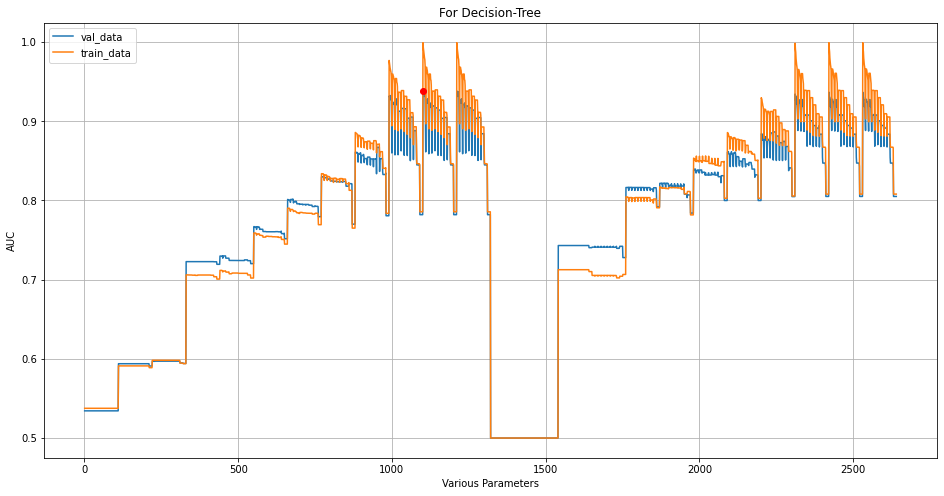

In [315]:
plt.figure(figsize=(16, 8))
plt.plot(cnt, dt_accuracy_val, label='val_data')
plt.plot(cnt, dt_accuracy_train, label='train_data')
plt.plot(dt_best, dt_accu_best, marker='o', color='red')
plt.grid()
plt.xlabel("Various Parameters")
plt.ylabel("AUC")
plt.title("For Decision-Tree")
plt.legend(loc='upper left')
plt.show()

In [316]:
mdt_classifier = DecisionTreeClassifier(criterion='gini',max_depth=50,min_samples_leaf=1,min_samples_split=3,random_state=42)
mdt_classifier.fit(mX_train,my_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=50, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [317]:
mdt_predictions = mdt_classifier.predict(mX_test)
print(mdt_predictions.shape)
mdt_predictions

(1627, 4)


array([[0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       ...,
       [0, 0, 0, 1],
       [0, 0, 0, 0],
       [0, 0, 0, 0]])

In [318]:
# evaluation
mdt_auc = metrics.roc_auc_score(my_test, mdt_predictions)
print("accuracy = ",mdt_auc)

accuracy =  0.9212190152028727


##**Bi-Directional LSTM**

### **Model Preparation**

In [357]:
from tensorflow.keras import regularizers

In [468]:
def lstm_model(n_features, n_outputs):
    model = Sequential()
    model.add(Bidirectional(LSTM(120, activation='relu', return_sequences=True), input_shape=(1, n_features)))
    #model.add(Bidirectional(LSTM(500, activation='relu', return_sequences=True)))
    #model.add(Bidirectional(LSTM(36, activation='relu', return_sequences=True)))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(36))
    model.add(Dense(n_outputs, activation="sigmoid"))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy','AUC'])
    print(model.summary())
    return model

### **Input Preparation**

In [469]:
n_inputs, n_outputs = mdf_X.shape[1], mdf_Y.shape[1]

In [470]:
n_samples = len(mX_train)
n_features = n_inputs
train_X = mX_train.to_numpy().reshape(n_samples, 1, n_features)
train_y = my_train.to_numpy()

###**Model Fitting**

In [471]:
from keras.models import Sequential
from keras.layers import Dense, Bidirectional, LSTM, Dropout, BatchNormalization, Flatten

In [472]:
lstm_mod = lstm_model(n_inputs, n_outputs)

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_27 (Bidirectio (None, 1, 240)            961920    
_________________________________________________________________
flatten_20 (Flatten)         (None, 240)               0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 240)               0         
_________________________________________________________________
dense_40 (Dense)             (None, 36)                8676      
_________________________________________________________________
dense_41 (Dense)             (None, 4)                 148       
Total params: 970,744
Trainable params: 970,744
Non-trainable params: 0
_________________________________________________________________
None


In [473]:
history = lstm_mod.fit(train_X, train_y, epochs=40, validation_split=0.2)

Epoch 1/40
163/163 [==============================] - 5s 15ms/step - loss: 0.3025 - accuracy: 0.6226 - auc: 0.8294 - val_loss: 0.1419 - val_accuracy: 0.5880 - val_auc: 0.9619
Epoch 2/40
163/163 [==============================] - 2s 11ms/step - loss: 0.1424 - accuracy: 0.6579 - auc: 0.9647 - val_loss: 0.1034 - val_accuracy: 0.7325 - val_auc: 0.9816
Epoch 3/40
163/163 [==============================] - 2s 11ms/step - loss: 0.1148 - accuracy: 0.7123 - auc: 0.9795 - val_loss: 0.1015 - val_accuracy: 0.6287 - val_auc: 0.9817
Epoch 4/40
163/163 [==============================] - 2s 11ms/step - loss: 0.1033 - accuracy: 0.7130 - auc: 0.9826 - val_loss: 0.0882 - val_accuracy: 0.6787 - val_auc: 0.9844
Epoch 5/40
163/163 [==============================] - 2s 11ms/step - loss: 0.0892 - accuracy: 0.7132 - auc: 0.9872 - val_loss: 0.0827 - val_accuracy: 0.7356 - val_auc: 0.9862
Epoch 6/40
163/163 [==============================] - 2s 11ms/step - loss: 0.0912 - accuracy: 0.7228 - auc: 0.9871 - val_loss

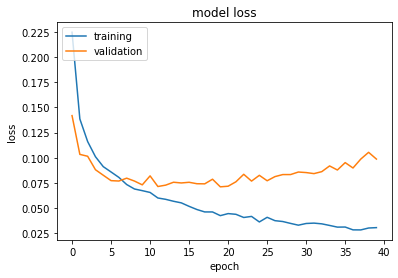

In [474]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

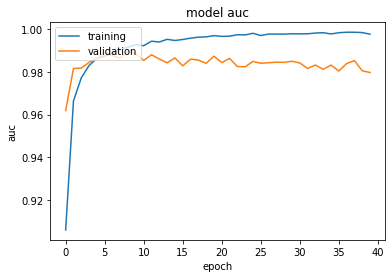

In [475]:
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('model auc')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

###**Prediction**

In [476]:
n_samples_test = len(mX_test)
n_features = n_inputs
lstm_test_X = mX_test.to_numpy().reshape(n_samples_test, 1, n_features)

In [477]:
lstm_predictions = lstm_mod.predict(lstm_test_X)

lstm_predictions[lstm_predictions > 0.5] = 1
lstm_predictions[lstm_predictions <= 0.5] = 0
lstm_predictions

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]], dtype=float32)

In [478]:
# evaluation
lstm_auc = metrics.roc_auc_score(my_test, lstm_predictions)
print("AUC = ",lstm_auc)

AUC =  0.929043864576445


##**Baseline Neural Network**

In [479]:
n_inputs, n_outputs = mdf_X.shape[1], mdf_Y.shape[1]

###**PCA (Optional)**

In [480]:
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import random as sparse_random

In [481]:
def transform_data(X_arg, n):
    print("transform_data is called", n)
    svd = TruncatedSVD(n_components=int(n - 1), n_iter=7, random_state=42)
    tr_X = svd.fit(X_arg)
    X_vals = tr_X.transform(X_arg)
    
    X_vals = pd.DataFrame(X_vals)
    print(X_vals.shape)
    return X_vals, n - 1

In [482]:
X_features, n_inputs_pca = transform_data(mdf_X, mdf_X.shape[1])

transform_data is called 881
(8132, 880)


In [483]:
# Sparsity after transformation

a = (X_features.to_numpy() == 0).mean()
print("Sparsity of fingerprints data is {}".format(a))

Sparsity of fingerprints data is 0.020123641729642712


###**Model Fitting**

In [517]:
def get_model_baseline(n_inputs, n_outputs ):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(240, input_dim=n_inputs,  kernel_initializer='he_uniform', activation='relu'))
    model.add(Dropout(0.5))
    model.add(tf.keras.layers.Dense(120, activation='relu'))
    #model.add(tf.keras.layers.LSTM(120, activation='relu'))
    model.add(Dropout(0.5))
    model.add(tf.keras.layers.Dense(60, activation='relu'))
    model.add(Dropout(0.5))
    model.add(tf.keras.layers.Dense(n_outputs, activation='sigmoid'))
    model.compile( loss='BinaryCrossentropy', optimizer='adam', metrics=['accuracy', 'AUC'])
    return model

In [518]:
import numpy as np
from keras.layers import Dropout

bs_x_train, bs_Y_train = np.array(mX_train), np.array(my_train)

#Reshape the data into 3-D array
#bs_x_train = np.reshape(bs_x_train, (bs_x_train.shape[0],bs_x_train.shape[1], 1))
#bs_x_train.shape

In [519]:
import tensorflow as tf 

In [520]:
bs_mod = get_model_baseline(n_inputs, n_outputs)

In [521]:
history = bs_mod.fit(mX_train, my_train, epochs=100, validation_split=0.15)

Epoch 1/100
173/173 [==============================] - 2s 7ms/step - loss: 0.4844 - accuracy: 0.4886 - auc: 0.6377 - val_loss: 0.2248 - val_accuracy: 0.5891 - val_auc: 0.9304
Epoch 2/100
173/173 [==============================] - 1s 4ms/step - loss: 0.2689 - accuracy: 0.5989 - auc: 0.8661 - val_loss: 0.1378 - val_accuracy: 0.6895 - val_auc: 0.9678
Epoch 3/100
173/173 [==============================] - 1s 4ms/step - loss: 0.1907 - accuracy: 0.6529 - auc: 0.9338 - val_loss: 0.1148 - val_accuracy: 0.6537 - val_auc: 0.9793
Epoch 4/100
173/173 [==============================] - 1s 4ms/step - loss: 0.1638 - accuracy: 0.6471 - auc: 0.9507 - val_loss: 0.1043 - val_accuracy: 0.7008 - val_auc: 0.9837
Epoch 5/100
173/173 [==============================] - 1s 4ms/step - loss: 0.1443 - accuracy: 0.6755 - auc: 0.9617 - val_loss: 0.1023 - val_accuracy: 0.6496 - val_auc: 0.9828
Epoch 6/100
173/173 [==============================] - 1s 4ms/step - loss: 0.1359 - accuracy: 0.6720 - auc: 0.9670 - val_loss

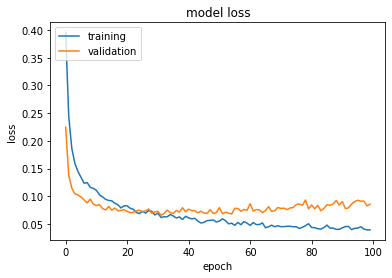

In [522]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

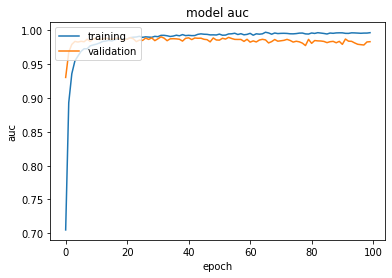

In [524]:
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('model auc')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

###**Prediction**

In [525]:
#bs_x_test = np.array(X_test)

#Reshape the data into 3-D array
#bs_x_test = np.reshape(bs_x_test, (bs_x_test.shape[0],bs_x_test.shape[1],1))

In [526]:
bs_predictions = bs_mod.predict(mX_test)

bs_predictions[bs_predictions > 0.5] = 1
bs_predictions[bs_predictions <= 0.5] = 0
bs_predictions

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]], dtype=float32)

In [527]:
bs_auc = metrics.roc_auc_score(my_test,bs_predictions)
print("AUC = ",bs_auc)

AUC =  0.9353991698078712


##**Random Forests**

In [337]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

In [338]:
# Random Forest
# Hyper-tunning the 'criterion', 'n_estimators', 'max_depth', 'min_sample_leaf' and 'min_sample_split' parameter
criterion = ['gini', 'entropy']
n_estimators = [1,5,10,50,100]
max_depth = [1,2,3,4,5,6,7,8,10,20,50]
min_samples_leaf = [1,2,3,4,5,6,7,8,10,20,50]
min_samples_split = [2,3,4,5,6,7,8,10,20,50]
rf_accuracy_val = []
rf_accuracy_train = []
parameter = []
rf_df = pd.DataFrame(columns=['Parameters', 'val_Accuracy', 'train_Accuracy'])
count = 0
cnt = []

for i in criterion:
    for j in max_depth:
        for k in min_samples_leaf:
            for l in min_samples_split:
                for m in n_estimators:
                  count+=1
                  rf_clf = RandomForestClassifier(criterion=i, max_depth=j, min_samples_leaf=k, min_samples_split=l, n_estimators=m, random_state=42)
                  rf_clf.fit(mX_val_train, my_val_train)
                  rf_pred = rf_clf.predict(mX_val)
                  rf_acc = metrics.roc_auc_score(my_val, rf_pred)
                  rf_accuracy_val.append(rf_acc)
                  
                  rf_pred = rf_clf.predict(mX_val_train)
                  rf_acc = metrics.roc_auc_score(my_val_train, rf_pred)
                  rf_accuracy_train.append(rf_acc)
                  cnt.append(count)
                  para = '[criterion = '+str(i)+', max_depth = '+str(j)+', min_sample_leaf = '+str(k)+', min_sample_split = '+str(l)+', n_estimators = '+str(m)+']'
                  parameter.append(para)

In [339]:
rf_df['Parameters'] = parameter
rf_df['val_Accuracy'] = rf_accuracy_val
rf_df['train_Accuracy'] = rf_accuracy_train
rf_df['difference'] = abs(rf_df['val_Accuracy'] - rf_df['train_Accuracy'])
rf_df["count"] = cnt
rfdf = rf_df[rf_df.iloc[:,1]<rf_df.iloc[:,2]]

rf_best, rf_accu_best, best_para = rfdf.sort_values(['val_Accuracy','difference'], ascending=[False,True]).head(1)[['count', 'val_Accuracy', 'Parameters']].values[0]
print("Best Parameter for Random Forest =", best_para, rf_accu_best)

Best Parameter for Random Forest = [criterion = entropy, max_depth = 50, min_sample_leaf = 1, min_sample_split = 3, n_estimators = 50] 0.9392337819938883


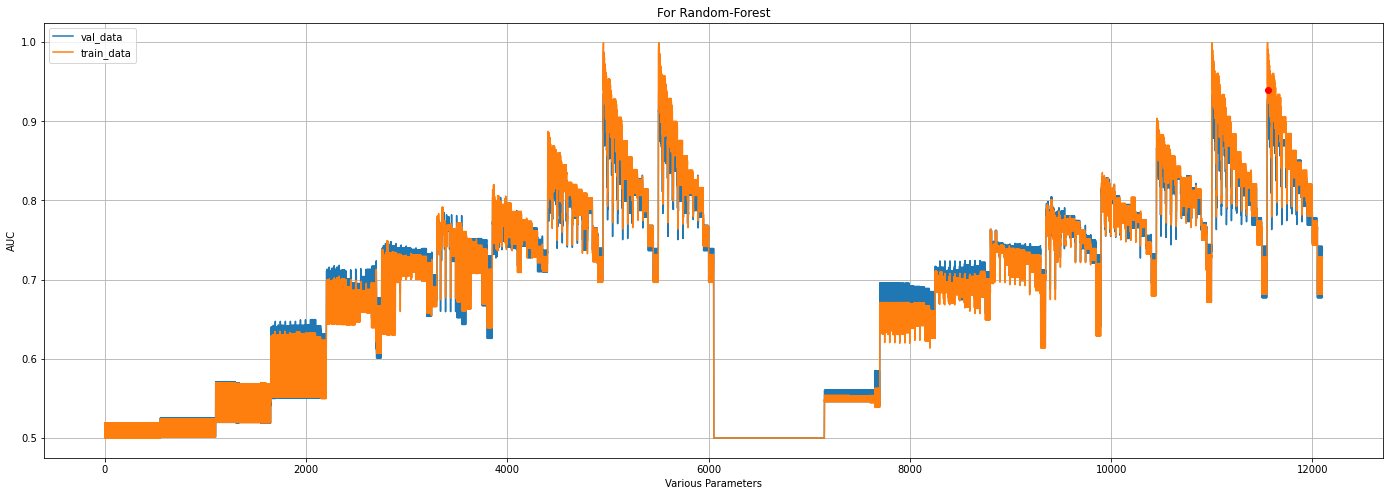

In [340]:
plt.figure(figsize=(24, 8))
plt.plot(cnt, rf_accuracy_val, label='val_data')
plt.plot(cnt, rf_accuracy_train, label='train_data')
plt.plot(rf_best, rf_accu_best, marker='o', color='red')
plt.grid()
plt.xlabel("Various Parameters")
plt.ylabel("AUC")
plt.title("For Random-Forest")
plt.legend(loc='upper left')
plt.show()

In [341]:
mrf_classifier = RandomForestClassifier(criterion='gini',n_estimators=50,max_depth=50,min_samples_leaf=1,min_samples_split=3,random_state=42)

In [342]:
mrf_classifier.fit(mX_train,my_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=50, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [343]:
# predict
mrf_predictions = mrf_classifier.predict(mX_test)
print(mrf_predictions.shape)
mrf_predictions

(1627, 4)


array([[0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       ...,
       [0, 0, 0, 1],
       [0, 0, 0, 0],
       [0, 0, 0, 0]])

In [344]:
# evaluation
mrf_auc = metrics.roc_auc_score(my_test, mrf_predictions)
print("AUC = ",mrf_auc)

AUC =  0.9180319603252538


##**Model Comparison & Save .h5/.pkl file**

In [531]:
multi_mods_acc = {'mdt_classifier': mdt_auc,'lstm_mod':lstm_auc,'bs_mod': bs_auc, 'mrf_classifier':mrf_auc}
multi_mods = {'mdt_classifier': mdt_classifier,'lstm_mod':lstm_mod,'bs_mod':bs_mod,'mrf_classifier':mrf_classifier}

In [532]:
selected_multi_model = max(multi_mods_acc, key=multi_mods_acc.get)
selected_multi_model

'bs_mod'

In [533]:
import h5py 
from sklearn.externals import joblib

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [546]:
for key in multi_mods_acc:
  if key != selected_multi_model and '_mod' in key:
    fname = today+'_M_'+key+'.h5'
    selected_model = multi_mods.get(key)
    selected_model.save(fname)
  elif i != selected_multi_model and '_classifier' in key:
    fname = today+'_M_'+key+'.pkl'
    joblib.dump(multi_mods.get(key), fname)
  elif key == selected_multi_model and '_mod' in selected_multi_model:
    fname = today+'_selected_M_'+key+'.h5'
    selected_model = multi_mods.get(key)
    selected_model.save(fname)
  else :
    fname = today+'_selected_M_'+key+'.pkl'
    joblib.dump(multi_mods.get(key), fname)

In [ ]:
'''if '_mod' in selected_multi_model:
  file_name = today+'_M_'+selected_multi_model+'.h5'
  selected_model = multi_mods.get(selected_multi_model)
  selected_model.save(file_name)
else :
  file_name = today+'_M_'+selected_multi_model+'.pkl'
  joblib.dump(multi_mods.get(selected_multi_model), file_name)'''

In [540]:
#for value in multi_mods_acc:
#  print(value)

mdt_classifier
lstm_mod
bs_mod
mrf_classifier


In [845]:
#multi_mods_acc

{'bs_mod': 0.9353991698078712,
 'lstm_mod': 0.929043864576445,
 'mdt_classifier': 0.9212190152028727,
 'mrf_classifier': 0.9180319603252538}

#**Modeling - Binary**

In [824]:
#selected_target = 'CHEMBL2842'
#binary_dataset_filename = '041321'+selected_target+'_Binary_modeling_dataset.csv'

In [825]:
import pandas as pd

df = pd.read_csv(binary_dataset_filename)
df.head(2)

,bioactivity_class,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,PubchemFP10,PubchemFP11,PubchemFP12,PubchemFP13,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP17,PubchemFP18,PubchemFP19,PubchemFP20,PubchemFP21,PubchemFP22,PubchemFP23,PubchemFP24,PubchemFP25,PubchemFP26,PubchemFP27,PubchemFP28,PubchemFP29,PubchemFP30,PubchemFP31,PubchemFP32,PubchemFP33,PubchemFP34,PubchemFP35,PubchemFP36,PubchemFP37,PubchemFP38,...,PubchemFP841,PubchemFP842,PubchemFP843,PubchemFP844,PubchemFP845,PubchemFP846,PubchemFP847,PubchemFP848,PubchemFP849,PubchemFP850,PubchemFP851,PubchemFP852,PubchemFP853,PubchemFP854,PubchemFP855,PubchemFP856,PubchemFP857,PubchemFP858,PubchemFP859,PubchemFP860,PubchemFP861,PubchemFP862,PubchemFP863,PubchemFP864,PubchemFP865,PubchemFP866,PubchemFP867,PubchemFP868,PubchemFP869,PubchemFP870,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,1,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,1,0,0,0,0,0,1,1,1,1,0,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [826]:
df_X = df.drop(columns='bioactivity_class')
print(df_X.shape)
df_X.head(2)

(2098, 881)


,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,PubchemFP10,PubchemFP11,PubchemFP12,PubchemFP13,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP17,PubchemFP18,PubchemFP19,PubchemFP20,PubchemFP21,PubchemFP22,PubchemFP23,PubchemFP24,PubchemFP25,PubchemFP26,PubchemFP27,PubchemFP28,PubchemFP29,PubchemFP30,PubchemFP31,PubchemFP32,PubchemFP33,PubchemFP34,PubchemFP35,PubchemFP36,PubchemFP37,PubchemFP38,PubchemFP39,...,PubchemFP841,PubchemFP842,PubchemFP843,PubchemFP844,PubchemFP845,PubchemFP846,PubchemFP847,PubchemFP848,PubchemFP849,PubchemFP850,PubchemFP851,PubchemFP852,PubchemFP853,PubchemFP854,PubchemFP855,PubchemFP856,PubchemFP857,PubchemFP858,PubchemFP859,PubchemFP860,PubchemFP861,PubchemFP862,PubchemFP863,PubchemFP864,PubchemFP865,PubchemFP866,PubchemFP867,PubchemFP868,PubchemFP869,PubchemFP870,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,0,0,0,0,0,1,1,1,1,0,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [827]:
df_Y = df.bioactivity_class
df_Y.shape

(2098,)

##**Split 80/20**

In [828]:
from sklearn.model_selection import train_test_split

In [829]:
y_train, y_test, X_train, X_test = train_test_split(df_Y, df_X, test_size=0.2)

In [830]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1678, 881), (1678,), (420, 881), (420,))

In [831]:
X_train.to_csv(selected_target+'binary_X_train.csv', index=False)
X_test.to_csv(selected_target+'binary_X_test.csv', index=False)
y_train.to_csv(selected_target+'binary_y_train.csv', index=False)
y_test.to_csv(selected_target+'binary_y_test.csv', index=False)

In [832]:
# Split validation set (20%)
y_val_train, y_val, X_val_train, X_val= train_test_split(y_train, X_train, test_size=0.15)

In [833]:
X_val_train.to_csv(selected_target+'binary_X_val_train.csv', index=False)
X_val.to_csv(selected_target+'binary_X_val.csv', index=False)
y_val_train.to_csv(selected_target+'binary_y_val_train.csv', index=False)
y_val.to_csv(selected_target+'binary_y_val.csv', index=False)

## **Decision Tree**

In [834]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

In [835]:
# Decision Tree
# Hyper-tunning the 'criterion', 'max_depth', 'min_sample_leaf' and 'min_sample_split' parameter
import matplotlib.pyplot as plt

criterion = ['gini', 'entropy']
max_depth = [1,2,3,4,5,6,7,8,10,20,50]
min_sample_leaf = [1,2,3,4,5,6,7,8,10,20,50]
min_sample_split = [2,3,4,5,6,7,8,10,20,50]
dt_accuracy_val = []
dt_accuracy_train = []
parameter = []
dt_df = pd.DataFrame(columns=['Parameters', 'val_Accuracy', 'train_Accuracy'])
count = 0
cnt = []

for i in criterion:
    for j in max_depth:
        for k in min_sample_leaf:
            for l in min_sample_split:
                count+=1
                dt_clf = DecisionTreeClassifier(criterion=i, max_depth=j, min_samples_leaf=k, min_samples_split=l, random_state=42)
                dt_clf.fit(X_val_train, y_val_train)
                dt_pred = dt_clf.predict(X_val)
                dt_acc = metrics.roc_auc_score(y_val, dt_pred)
                dt_accuracy_val.append(dt_acc)
                
                dt_pred = dt_clf.predict(X_val_train)
                dt_acc = metrics.roc_auc_score(y_val_train, dt_pred)
                dt_accuracy_train.append(dt_acc)
                cnt.append(count)
                para = '[criterion = '+str(i)+', max_depth = '+str(j)+', min_sample_leaf = '+str(k)+', min_sample_split = '+str(l)+']'
                parameter.append(para)

In [836]:
dt_df['Parameters'] = parameter
dt_df['val_Accuracy'] = dt_accuracy_val
dt_df['train_Accuracy'] = dt_accuracy_train
dt_df['difference'] = abs(dt_df['val_Accuracy'] - dt_df['train_Accuracy'])
dt_df["count"] = cnt
dtdf = dt_df[dt_df.iloc[:,1]<dt_df.iloc[:,2]]

dt_best, dt_accu_best, best_para = dtdf.sort_values(['val_Accuracy','difference'], ascending=[False,True]).head(1)[['count', 'val_Accuracy', 'Parameters']].values[0]
print("Best Parameter for Decision Tree =", best_para, dt_accu_best)

Best Parameter for Decision Tree = [criterion = gini, max_depth = 20, min_sample_leaf = 1, min_sample_split = 2] 0.9685193363194751


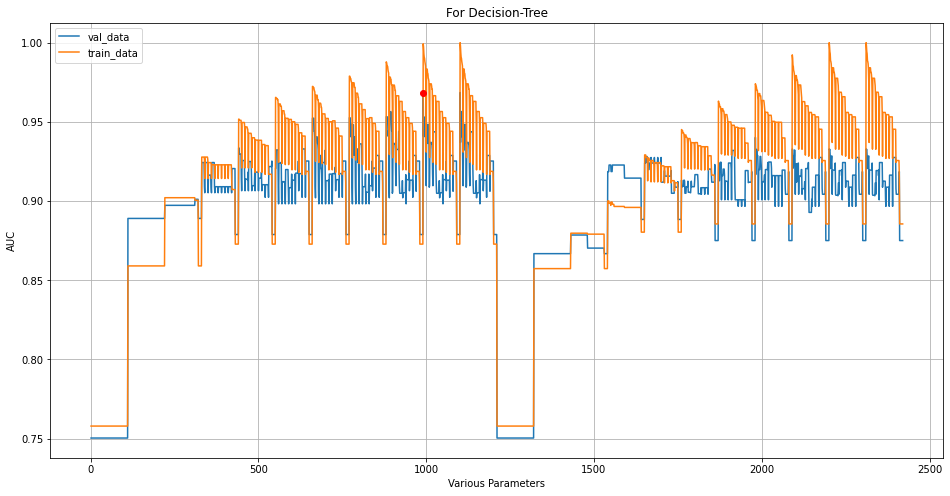

In [837]:
plt.figure(figsize=(16, 8))
plt.plot(cnt, dt_accuracy_val, label='val_data')
plt.plot(cnt, dt_accuracy_train, label='train_data')
plt.plot(dt_best, dt_accu_best, marker='o', color='red')
plt.grid()
plt.xlabel("Various Parameters")
plt.ylabel("AUC")
plt.title("For Decision-Tree")
plt.legend(loc='upper left')
plt.show()

In [838]:
dt_classifier = DecisionTreeClassifier(criterion='gini', max_depth=20, min_samples_leaf=1, min_samples_split=2, random_state=42)
dt_classifier.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=20, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [839]:
#predict
dt_predictions = dt_classifier.predict(X_test)

In [840]:
# evaluation
dt_auc = metrics.roc_auc_score(y_test, dt_predictions)
print("AUC = ",dt_auc)

AUC =  0.9442735042735043


## **Random Forest**

In [841]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

In [842]:
# Random Forest
# Hyper-tunning the 'criterion', 'n_estimators', 'max_depth', 'min_sample_leaf' and 'min_sample_split' parameter
criterion = ['gini', 'entropy']
n_estimators = [1,5,10,50,100]
max_depth = [1,2,3,4,5,6,7,8,10,20,50]
min_samples_leaf = [1,2,3,4,5,6,7,8,10,20,50]
min_samples_split = [2,3,4,5,6,7,8,10,20,50]
rf_accuracy_val = []
rf_accuracy_train = []
parameter = []
rf_df = pd.DataFrame(columns=['Parameters', 'val_Accuracy', 'train_Accuracy'])
count = 0
cnt = []

for i in criterion:
    for j in max_depth:
        for k in min_sample_leaf:
            for l in min_sample_split:
                for m in n_estimators:
                  count+=1
                  rf_clf = RandomForestClassifier(criterion=i, max_depth=j, min_samples_leaf=k, min_samples_split=l, n_estimators=m, random_state=42)
                  rf_clf.fit(X_val_train, y_val_train)
                  rf_pred = rf_clf.predict(X_val)
                  rf_acc = metrics.roc_auc_score(y_val, rf_pred)
                  rf_accuracy_val.append(rf_acc)
                  
                  rf_pred = rf_clf.predict(X_val_train)
                  rf_acc = metrics.roc_auc_score(y_val_train, rf_pred)
                  rf_accuracy_train.append(rf_acc)
                  cnt.append(count)
                  para = '[criterion = '+str(i)+', max_depth = '+str(j)+', min_sample_leaf = '+str(k)+', min_sample_split = '+str(l)+', n_estimators = '+str(m)+']'
                  parameter.append(para)

In [843]:
rf_df['Parameters'] = parameter
rf_df['val_Accuracy'] = rf_accuracy_val
rf_df['train_Accuracy'] = rf_accuracy_train
rf_df['difference'] = abs(rf_df['val_Accuracy'] - rf_df['train_Accuracy'])
rf_df["count"] = cnt
rfdf = rf_df[rf_df.iloc[:,1]<rf_df.iloc[:,2]]

rf_best, rf_accu_best, best_para = rfdf.sort_values(['val_Accuracy','difference'], ascending=[False,True]).head(1)[['count', 'val_Accuracy', 'Parameters']].values[0]
print("Best Parameter for Random Forest =", best_para, rf_accu_best)

Best Parameter for Random Forest = [criterion = entropy, max_depth = 50, min_sample_leaf = 3, min_sample_split = 7, n_estimators = 100] 0.975206611570248


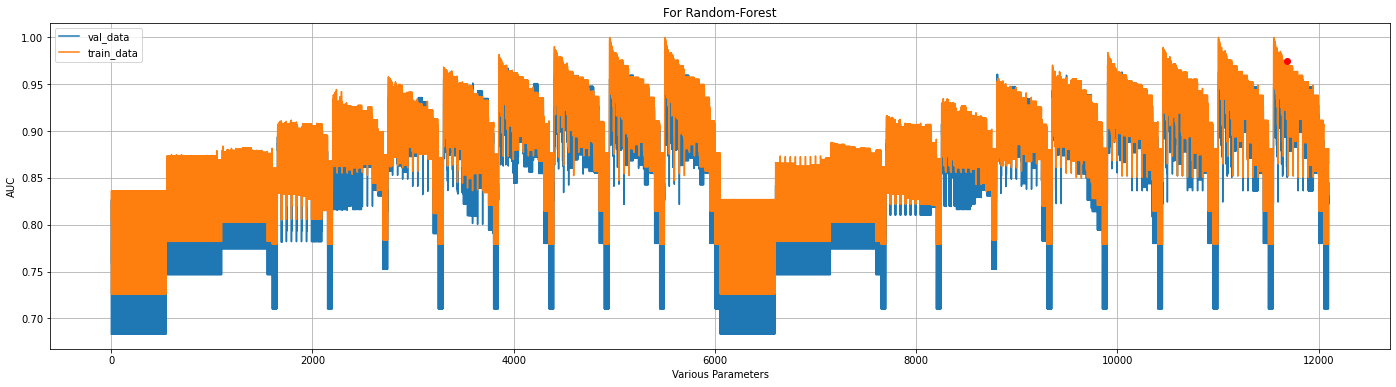

In [844]:
plt.figure(figsize=(24, 6))
plt.plot(cnt, rf_accuracy_val, label='val_data')
plt.plot(cnt, rf_accuracy_train, label='train_data')
plt.plot(rf_best, rf_accu_best, marker='o', color='red')
plt.grid()
plt.xlabel("Various Parameters")
plt.ylabel("AUC")
plt.title("For Random-Forest")
plt.legend(loc='upper left')
plt.show()

In [847]:
rf_classifier = RandomForestClassifier(criterion='entropy',max_depth=50,min_samples_leaf=3,min_samples_split=7,n_estimators=100,random_state=42)

In [848]:
rf_classifier.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=50, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=7,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [849]:
# predict
rf_predictions = rf_classifier.predict(X_test)

In [850]:
# evaluation
rf_auc = metrics.roc_auc_score(y_test, rf_predictions)
print("AUC = ",rf_auc)

AUC =  0.941025641025641


##**Support Vector Machine**

In [851]:
from sklearn.svm import SVC

In [852]:
# Hyper-tunning the 'kernel' and 'gamma' parameter
svc_dict = {'auto': ['linear'], 'scale': ['linear', 'poly', 'rbf', 'sigmoid']}
svc_accuracy_val = []
svc_accuracy_train = []
svc_df = pd.DataFrame(columns=['Parameters', 'val_Accuracy', 'train_Accuracy'])
parameter = []
cnt = []
count = 0
for i in svc_dict:
    for j in svc_dict[i]:
        count+=1
        svc_clf = SVC(kernel=j, gamma=i, random_state=42)
        svc_clf.fit(X_val_train, y_val_train)
        svc_pred = svc_clf.predict(X_val)
        svc_acc = metrics.roc_auc_score(y_val,svc_pred)
        svc_accuracy_val.append(svc_acc)

        svc_pred = svc_clf.predict(X_val_train)
        svc_acc = metrics.roc_auc_score(y_val_train, svc_pred)
        svc_accuracy_train.append(svc_acc)
        cnt.append(count)
        para = '[gamma = '+str(i)+', kernel = '+str(j)+']'
        parameter.append(para)

In [853]:
svc_df['Parameters'] = parameter
svc_df['val_Accuracy'] = svc_accuracy_val
svc_df['train_Accuracy'] = svc_accuracy_train
svc_df['difference'] = abs(svc_df['val_Accuracy'] - svc_df['train_Accuracy'])
svc_df["count"] = cnt
svcdf = svc_df[svc_df.iloc[:,1]<svc_df.iloc[:,2]]

svc_best, svc_accu_best, best_para = svcdf.sort_values(['val_Accuracy','difference'], ascending=[False,True]).head(1)[['count', 'val_Accuracy', 'Parameters']].values[0]
print('Best Parameter for Support Vector Machine(SVC) = ', best_para, svc_accu_best)

Best Parameter for Support Vector Machine(SVC) =  [gamma = scale, kernel = poly] 0.9675730237839885


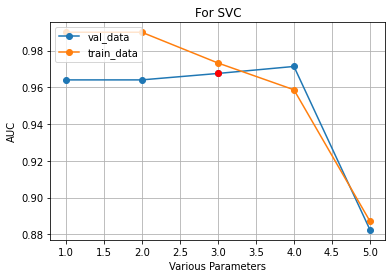

In [854]:
plt.plot(cnt, svc_accuracy_val, label='val_data', marker ='o')
plt.plot(cnt, svc_accuracy_train, label='train_data', marker='o')
plt.plot(svc_best, svc_accu_best, marker='o', color='red')
plt.grid()
plt.xlabel("Various Parameters")
plt.ylabel("AUC")
plt.title("For SVC")
plt.legend(loc='upper left')
plt.show()

In [855]:
svm_classifier = SVC(kernel='poly',gamma='scale',random_state=42)
svm_classifier.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='poly',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

In [856]:
#predict
svm_predictions = svm_classifier.predict(X_test)

In [857]:
svm_auc = metrics.roc_auc_score(y_test, svm_predictions)
print("AUC = ",svm_auc)

AUC =  0.9292307692307693


##**Logistic Regression**

In [858]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

In [859]:
# Hyper-tunning the 'penalty' and 'solver' parameter
lr_dict = {'l1': ['liblinear', 'saga'], 'l2': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
lr_accuracy_val = []
lr_accuracy_train = []
lr_accuracy_cv = []
lr_df = pd.DataFrame(columns=['Parameters', 'val_Accuracy', 'train_Accuracy'])
parameter = []
cnt = []
count = 0

for i in lr_dict:
    for j in lr_dict[i]:
        count+=1
        lr_clf = LogisticRegression(penalty=i, solver=j, random_state=42)
        lr_clf.fit(X_val_train, y_val_train)
        lr_pred = lr_clf.predict(X_val)
        lr_acc = metrics.roc_auc_score(y_val, lr_pred)
        lr_accuracy_val.append(lr_acc)

        lr_pred = lr_clf.predict(X_val_train)
        lr_acc = metrics.roc_auc_score(y_val_train, lr_pred)
        lr_accuracy_train.append(lr_acc)
        cnt.append(count)
        para = '[penalty = '+str(i)+', solver = '+str(j)+']'
        parameter.append(para)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_m

In [860]:
lr_df['Parameters'] = parameter
lr_df['val_Accuracy'] = lr_accuracy_val
lr_df['train_Accuracy'] = lr_accuracy_train
lr_df['difference'] = abs(lr_df['val_Accuracy'] - lr_df['train_Accuracy'])
lr_df["count"] = cnt
lrdf = lr_df[lr_df.iloc[:,1]<lr_df.iloc[:,2]]
lr_best, lr_accu_best, best_para = lrdf.sort_values(['val_Accuracy','difference'], ascending=[False,True]).head(1)[['count', 'val_Accuracy', 'Parameters']].values[0]
print('Best Parameters for Logistic Regression =', best_para, lr_accu_best)

Best Parameters for Logistic Regression = [penalty = l2, solver = newton-cg] 0.9561226421045992


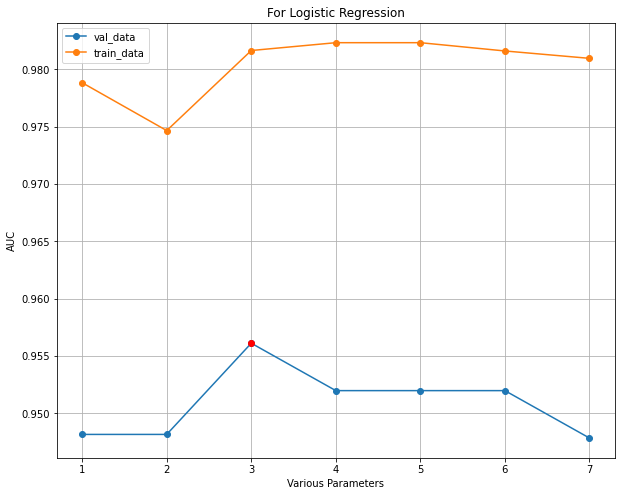

In [861]:
plt.figure(figsize=(10,8))
plt.plot(cnt, lr_accuracy_val, label='val_data', marker ='o')
plt.plot(cnt, lr_accuracy_train, label='train_data', marker='o')
plt.plot(lr_best, lr_accu_best, marker='o', color='red')
plt.grid()
plt.xlabel("Various Parameters")
plt.ylabel("AUC")
plt.title("For Logistic Regression")
plt.legend(loc='upper left')
plt.show()

In [862]:
lr_classifier = LogisticRegression(penalty='l2', solver='newton-cg', random_state=42)
lr_classifier.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

In [863]:
#predict
lr_predictions = lr_classifier.predict(X_test)

In [864]:
lr_auc = metrics.roc_auc_score(y_test, lr_predictions)
print("AUC = ",lr_auc)

AUC =  0.9273504273504273


##**Deep Neural Network**

In [865]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.4.1


In [866]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=150, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False
)

In [913]:
dnn_mod = keras.Sequential()
# Deep Neural Network(DNN)
dnn_mod = keras.Sequential([
              layers.Dense(36, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001), input_shape=[len(X_train.keys())]),
              #layers.Dense(16, activation='relu'),
              #layers.Dense(8, activation='relu'),
              layers.Dropout(0.5),
              layers.Dense(32, activation='relu'),
              layers.Dropout(0.5),#
              layers.Dense(4, activation='relu'),
              layers.Dropout(0.5),
              layers.Dense(1, activation='sigmoid')
              ])

In [914]:
dnn_mod.compile(optimizer='adam',
        loss=tf.keras.losses.binary_crossentropy,
        metrics=['accuracy'])

In [915]:
history = dnn_mod.fit(X_train, y_train, epochs=100, validation_split=0.2, callbacks=callback)

Epoch 1/100
42/42 [==============================] - 1s 9ms/step - loss: 0.7657 - accuracy: 0.5207 - val_loss: 0.7206 - val_accuracy: 0.6101
Epoch 2/100
42/42 [==============================] - 0s 3ms/step - loss: 0.7216 - accuracy: 0.5410 - val_loss: 0.6392 - val_accuracy: 0.7381
Epoch 3/100
42/42 [==============================] - 0s 3ms/step - loss: 0.6809 - accuracy: 0.5838 - val_loss: 0.6132 - val_accuracy: 0.7917
Epoch 4/100
42/42 [==============================] - 0s 4ms/step - loss: 0.6485 - accuracy: 0.6334 - val_loss: 0.5355 - val_accuracy: 0.8095
Epoch 5/100
42/42 [==============================] - 0s 3ms/step - loss: 0.6276 - accuracy: 0.6696 - val_loss: 0.4784 - val_accuracy: 0.8452
Epoch 6/100
42/42 [==============================] - 0s 3ms/step - loss: 0.5463 - accuracy: 0.7389 - val_loss: 0.4611 - val_accuracy: 0.8214
Epoch 7/100
42/42 [==============================] - 0s 3ms/step - loss: 0.5503 - accuracy: 0.7780 - val_loss: 0.4038 - val_accuracy: 0.8542
Epoch 8/100
4

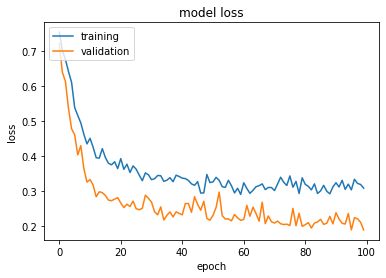

In [916]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

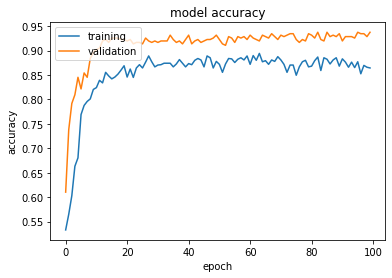

In [917]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

In [918]:
#predict
dnn_predictions = dnn_mod.predict_classes(X_test)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [919]:
#evaluation
dnn_auc = metrics.roc_auc_score(y_test, dnn_predictions)
print("AUC = ",dnn_auc)

AUC =  0.9109401709401709


##**Gradient Boosting**

In [920]:
from sklearn.ensemble import GradientBoostingClassifier

In [921]:
# Gradient Boosting
gb_classifier = GradientBoostingClassifier(random_state=42)
gb_classifier.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [922]:
#predict
gb_predictions = gb_classifier.predict(X_test)

In [923]:
#evaluation
gb_auc = metrics.roc_auc_score(y_test, gb_predictions)
print("AUC = ",gb_auc)

AUC =  0.9369230769230771


##**Model Comparison & Save .h5/.pkl file**

In [924]:
binary_mods_acc = {'dt_classifier': dt_auc,'rf_classifier':rf_auc,'svm_classifier': svm_auc, 'lr_classifier':lr_auc, 'dnn_mod':dnn_auc, 'gb_classifier':gb_auc}
binary_mods = {'dt_classifier': dt_classifier,'rf_classifier':rf_classifier,'svm_classifier': svm_classifier, 'lr_classifier':lr_classifier, 'dnn_mod':dnn_mod, 'gb_classifier':gb_classifier}

In [925]:
selected_binary_model = max(binary_mods_acc, key=binary_mods_acc.get)
print(selected_binary_model,' AUC =',binary_mods_acc[selected_binary_model])

dt_classifier  AUC = 0.9442735042735043


In [926]:
import h5py 
from sklearn.externals import joblib

In [927]:
for k in binary_mods_acc:
  if k != selected_binary_model and '_mod' in k:
    fname = today+selected_target+'_'+'_B_'+k+'.h5'
    selected_model = binary_mods.get(k)
    selected_model.save(fname)
    #print(1)
  elif k != selected_binary_model and '_classifier' in k:
    fname = today+selected_target+'_'+'_B_'+k+'.pkl'
    joblib.dump(binary_mods.get(k), fname)
    #print(2)
  elif k == selected_binary_model and '_mod' in selected_binary_model:
    fname = today+selected_target+'_'+'_selected_B_'+k+'.h5'
    selected_model = binary_mods.get(k)
    selected_model.save(fname)
    #print(3)
  else:
    fname = today+selected_target+'_'+'_selected_B_'+k+'.pkl'
    joblib.dump(binary_mods.get(k), fname)
    #print(4)

In [928]:
#binary_mods_acc

{'dnn_mod': 0.9109401709401709,
 'dt_classifier': 0.9442735042735043,
 'gb_classifier': 0.9369230769230771,
 'lr_classifier': 0.9273504273504273,
 'rf_classifier': 0.941025641025641,
 'svm_classifier': 0.9292307692307693}